<a href="https://colab.research.google.com/github/juniismai02/kanker-kulit-tf-vggnet-mobilenet-juniismail/blob/main/Kombinasi_Arsitektur_VGGnet_Dan_Mobilenet_Untuk_Klasifikasi_Kanker_Kulit_JuniIsmail.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Penerapan Transfer Learning Dengan Kombinasi Arsitektur VGGnet Dan Mobilenet Untuk Klasifikasi Kanker Kulit

# Bagian 1: Import Libraries dan Konfigurasi Awal

In [ ]:
# Import dependencies
import warnings
warnings.filterwarnings('ignore')
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import time
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Cek GPU dan mengaktifkan mixed precision untuk akselerasi
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    print("Name:", gpu.name, " Type:", gpu.device_type)

# Aktifkan mixed precision untuk mempercepat training jika GPU tersedia
if len(gpus) > 0:
    print("Enabling mixed precision training")
    tf.keras.mixed_precision.set_global_policy('mixed_float16')
    print('Compute dtype: %s' % tf.keras.mixed_precision.global_policy().compute_dtype)
    print('Variable dtype: %s' % tf.keras.mixed_precision.global_policy().variable_dtype)

# Mengatur parameter yang dioptimasi
IMG_SIZE = 224  # Ukuran yang optimal untuk VGG16 dan MobileNet
BATCH_SIZE = 16  # Batch size yang sesuai untuk memori GPU
EPOCHS = 150  # Lebih banyak epoch dengan early stopping yang dioptimasi
TARGET_SAMPLES = 800  # Jumlah sample yang lebih besar per kelas untuk data augmentation

# Path untuk Google Colab
DATASET_DIR_1 = '/content/skin-cancer-data/HAM10000_images_part_1/'
DATASET_DIR_2 = '/content/skin-cancer-data/HAM10000_images_part_2/'
metadata_path = '/content/skin-cancer-data/HAM10000_metadata.csv'

TensorFlow version: 2.18.0
Num GPUs Available:  1
Name: /physical_device:GPU:0  Type: GPU
Enabling mixed precision training
Compute dtype: float16
Variable dtype: float32


# Bagian 2: Download Dataset dan Persiapan Data

In [ ]:
# Fungsi untuk mengunduh dataset
def download_dataset():
    if not os.path.exists('/content/skin-cancer-data'):
        print("Dataset tidak ditemukan. Mengunduh dataset...")
        # Membuat direktori
        os.makedirs('/content/skin-cancer-data', exist_ok=True)

        # Download dataset menggunakan Kaggle API
        try:
            # Install Kaggle API
            import subprocess
            subprocess.run(["pip", "install", "-q", "kaggle"], check=True)

            # Buat direktori dan file konfigurasi Kaggle
            os.makedirs('/root/.kaggle', exist_ok=True)
            with open('/root/.kaggle/kaggle.json', 'w') as f:
                f.write('{"username":"juniismail","key":"d5034f3351b20d2c3e93d9e017f79574"}')
            os.chmod('/root/.kaggle/kaggle.json', 0o600)

            # Unduh dataset
            subprocess.run(["kaggle", "datasets", "download", "-d", "kmader/skin-cancer-mnist-ham10000", "--path", "/content"], check=True)
            subprocess.run(["unzip", "-q", "/content/skin-cancer-mnist-ham10000.zip", "-d", "/content/skin-cancer-data"], check=True)
            print("Dataset berhasil diunduh dan diekstrak.")
        except Exception as e:
            print(f"Error saat mengunduh dataset: {e}")
            print("Silakan unduh dataset secara manual.")
    else:
        print("Dataset sudah ada.")

# Download dataset dan load data
download_dataset()

# Periksa keberadaan file dan direktori
print(f"Metadata path exists: {os.path.exists(metadata_path)}")
print(f"Dataset dir 1 exists: {os.path.exists(DATASET_DIR_1)}")
print(f"Dataset dir 2 exists: {os.path.exists(DATASET_DIR_2)}")

# Baca metadata
df = pd.read_csv(metadata_path)
print("Dataset shape:", df.shape)
print(df.head())

# Fungsi untuk mendapatkan path gambar lengkap
def get_full_image_path(filename):
    path_1 = os.path.join(DATASET_DIR_1, filename+'.jpg')
    path_2 = os.path.join(DATASET_DIR_2, filename+'.jpg')

    if os.path.exists(path_1):
        return path_1
    elif os.path.exists(path_2):
        return path_2
    else:
        return None

# Buat kolom image_path
df['image_path'] = df['image_id'].apply(get_full_image_path)

# Periksa hasil
print(f"Jumlah path gambar yang valid: {df['image_path'].notna().sum()}")
print(f"Contoh path gambar: {df['image_path'].iloc[0]}")

# Hapus baris dengan path gambar yang tidak valid
df = df.dropna(subset=['image_path'])
print(f"Dataset shape setelah menghapus path invalid: {df.shape}")

Dataset tidak ditemukan. Mengunduh dataset...
Dataset berhasil diunduh dan diekstrak.
Metadata path exists: True
Dataset dir 1 exists: True
Dataset dir 2 exists: True
Dataset shape: (10015, 7)
     lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear
Jumlah path gambar yang valid: 10015
Contoh path gambar: /content/skin-cancer-data/HAM10000_images_part_1/ISIC_0027419.jpg
Dataset shape setelah menghapus path invalid: (10015, 8)


# Bagian 3: Eksplorasi Data dan Balancing

Kelas unik: ['akiec' 'bcc' 'bkl' 'df' 'mel' 'nv' 'vasc']
Jumlah sampel kelas akiec: 327
Jumlah sampel kelas bcc: 514
Jumlah sampel kelas bkl: 1099
Jumlah sampel kelas df: 115
Jumlah sampel kelas mel: 1113
Jumlah sampel kelas nv: 6705
Jumlah sampel kelas vasc: 142


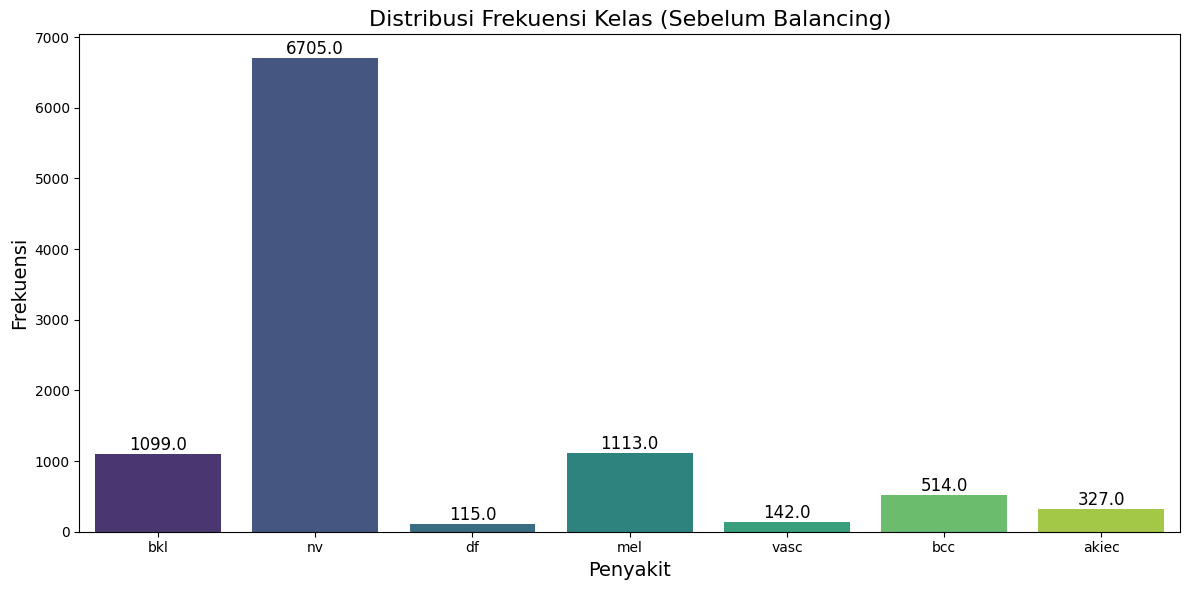


Pendekatan balancing data yang ditingkatkan...
Jumlah sampel kelas akiec setelah filtering: 327
Jumlah sampel kelas bcc setelah filtering: 514
Jumlah sampel kelas mel setelah filtering: 1113
Target sampel per kelas: 800
Balanced dataset shape: (2400, 8)

Distribusi Kelas Setelah Balancing:
Jumlah sampel kelas akiec setelah balancing: 800
Jumlah sampel kelas bcc setelah balancing: 800
Jumlah sampel kelas mel setelah balancing: 800


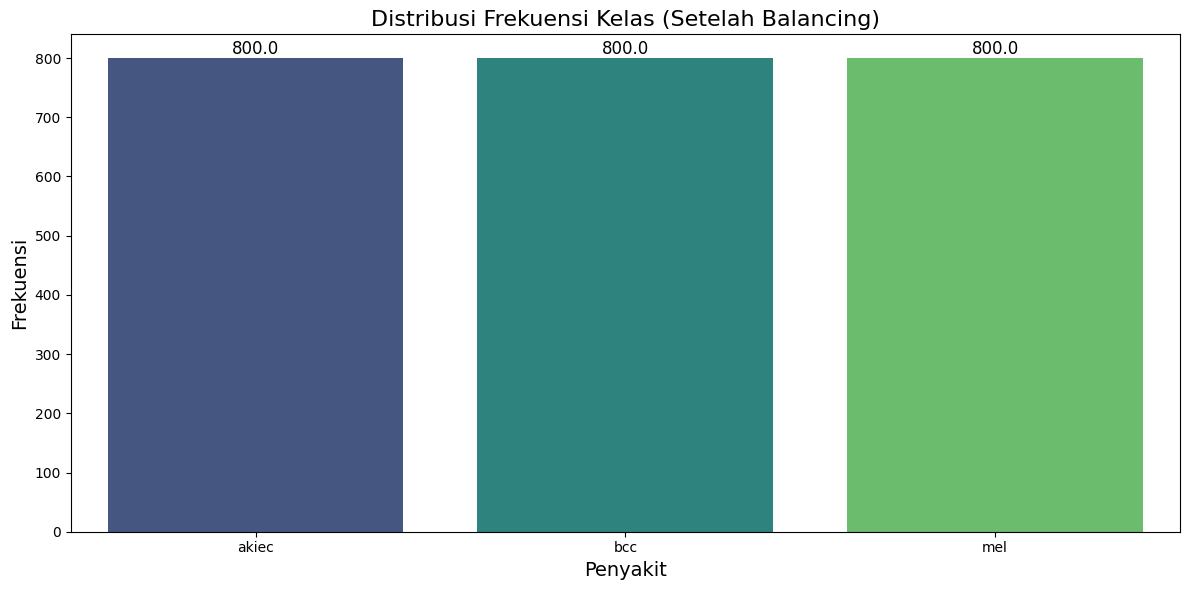

Train set size: 1920, Validation set size: 480

Distribusi Kelas Pada Train Set:
Jumlah sampel kelas akiec: 640
Jumlah sampel kelas bcc: 640
Jumlah sampel kelas mel: 640

Distribusi Kelas Pada Validation Set:
Jumlah sampel kelas akiec: 160
Jumlah sampel kelas bcc: 160
Jumlah sampel kelas mel: 160


In [ ]:
# Eksplorasi distribusi kelas
unique_labels = np.unique(df['dx'])
print("Kelas unik:", unique_labels)
class_counts = {}
for label in unique_labels:
    count = list(df['dx']).count(label)
    class_counts[label] = count
    print(f"Jumlah sampel kelas {label}: {count}")

# Visualisasi distribusi kelas awal
plt.figure(figsize=(12, 6))
ax = sns.countplot(x='dx', data=df, palette='viridis')
plt.xlabel('Penyakit', size=14)
plt.ylabel('Frekuensi', size=14)
plt.title('Distribusi Frekuensi Kelas (Sebelum Balancing)', size=16)

# Menambahkan label di atas bar
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width()/2., p.get_height()),
                ha='center', va='bottom', fontsize=12, color='black')

plt.tight_layout()
plt.show()

# Teknik balancing dataset yang ditingkatkan dan dikoreksi
print("\nPendekatan balancing data yang ditingkatkan...")

# Fokus hanya pada tipe kanker kulit utama untuk kajian tesis
selected_classes = ['bcc', 'mel', 'akiec']  # Karsinoma Sel Basal, Melanoma, dan Actinic Keratosis
df_filtered = df[df['dx'].isin(selected_classes)]

# Update unique_labels dan class_counts
unique_labels = np.unique(df_filtered['dx'])
class_counts = {}
for label in unique_labels:
    count = list(df_filtered['dx']).count(label)
    class_counts[label] = count
    print(f"Jumlah sampel kelas {label} setelah filtering: {count}")

# Tentukan target sampel untuk setiap kelas
min_class_count = min(class_counts.values())
target_samples = min(TARGET_SAMPLES, min_class_count * 3)  # Hindari oversampling berlebihan
print(f"Target sampel per kelas: {target_samples}")

# DataFrame untuk hasil yang sudah dibalance
balanced_df = pd.DataFrame()

# Lakukan balancing untuk setiap kelas
for label in unique_labels:
    class_df = df_filtered[df_filtered['dx'] == label]

    if len(class_df) > target_samples:
        # Under-sampling untuk kelas dengan sampel lebih banyak
        class_df = class_df.sample(target_samples, random_state=42)
    elif len(class_df) < target_samples:
        # Over-sampling untuk kelas dengan sampel lebih sedikit (dengan replacement)
        class_df = class_df.sample(target_samples, replace=True, random_state=42)

    # Gabungkan ke dataframe seimbang
    balanced_df = pd.concat([balanced_df, class_df], ignore_index=True)

# Periksa hasil balancing
print(f"Balanced dataset shape: {balanced_df.shape}")
print("\nDistribusi Kelas Setelah Balancing:")
for label in unique_labels:
    print(f"Jumlah sampel kelas {label} setelah balancing: {list(balanced_df['dx']).count(label)}")

# Visualisasi distribusi kelas setelah balancing
plt.figure(figsize=(12, 6))
ax = sns.countplot(x='dx', data=balanced_df, palette='viridis')
plt.xlabel('Penyakit', size=14)
plt.ylabel('Frekuensi', size=14)
plt.title('Distribusi Frekuensi Kelas (Setelah Balancing)', size=16)

# Menambahkan label di atas bar
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width()/2., p.get_height()),
                ha='center', va='bottom', fontsize=12, color='black')

plt.tight_layout()
plt.show()

# Split data menjadi train dan validation dengan stratifikasi
train_df, val_df = train_test_split(balanced_df, test_size=0.2, random_state=42, stratify=balanced_df['dx'])
print(f"Train set size: {train_df.shape[0]}, Validation set size: {val_df.shape[0]}")

# Cetak distribusi kelas di train dan validation untuk memastikan stratifikasi
print("\nDistribusi Kelas Pada Train Set:")
for label in unique_labels:
    print(f"Jumlah sampel kelas {label}: {list(train_df['dx']).count(label)}")

print("\nDistribusi Kelas Pada Validation Set:")
for label in unique_labels:
    print(f"Jumlah sampel kelas {label}: {list(val_df['dx']).count(label)}")

# Simpan dataframe untuk digunakan pada tahap berikutnya
train_df.to_csv('/content/train_df.csv', index=False)
val_df.to_csv('/content/val_df.csv', index=False)

# Bagian 4: Definisi Modul Attention dan Fungsi Evaluasi

In [ ]:
# Import packages yang dibutuhkan
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization, GlobalMaxPooling2D, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.layers import Multiply, Activation, Lambda, Add, Reshape
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

# Definisi kelas CBAM (Convolutional Block Attention Module)
class ChannelAttention(tf.keras.layers.Layer):
    def __init__(self, ratio=8, **kwargs):
        super(ChannelAttention, self).__init__(**kwargs)
        self.ratio = ratio

    def build(self, input_shape):
        channel = input_shape[-1]
        self.shared_dense_one = Dense(max(channel//self.ratio, 8),  # Minimal 8 neuron untuk mencegah bottleneck
                                    activation='relu',
                                    kernel_initializer='he_normal',
                                    kernel_regularizer=l2(1e-4),  # Tambahkan regularisasi L2
                                    use_bias=True)
        self.shared_dense_two = Dense(channel,
                                    kernel_initializer='he_normal',
                                    kernel_regularizer=l2(1e-4),  # Tambahkan regularisasi L2
                                    use_bias=True)
        super(ChannelAttention, self).build(input_shape)

    def call(self, inputs):
        # Average Pooling dengan pembulatan yang benar
        avg_pool = GlobalAveragePooling2D()(inputs)
        avg_pool = tf.expand_dims(tf.expand_dims(avg_pool, 1), 1)
        avg_pool = self.shared_dense_one(avg_pool)
        avg_pool = self.shared_dense_two(avg_pool)

        # Max Pooling dengan pembulatan yang benar
        max_pool = GlobalMaxPooling2D()(inputs)
        max_pool = tf.expand_dims(tf.expand_dims(max_pool, 1), 1)
        max_pool = self.shared_dense_one(max_pool)
        max_pool = self.shared_dense_two(max_pool)

        # Gabungkan dengan perhatian pada bobot
        cbam_feature = Add()([avg_pool, max_pool])
        cbam_feature = Activation('sigmoid')(cbam_feature)

        return Multiply()([inputs, cbam_feature])

    # Tambahkan metode get_config untuk serialisasi model
    def get_config(self):
        config = super(ChannelAttention, self).get_config()
        config.update({"ratio": self.ratio})
        return config

class SpatialAttention(tf.keras.layers.Layer):
    def __init__(self, kernel_size=7, **kwargs):
        super(SpatialAttention, self).__init__(**kwargs)
        self.kernel_size = kernel_size

    def build(self, input_shape):
        self.conv = Conv2D(filters=1,
                          kernel_size=self.kernel_size,
                          padding='same',
                          kernel_regularizer=l2(1e-4),  # Tambahkan regularisasi L2
                          activation='sigmoid',
                          kernel_initializer='he_normal')
        super(SpatialAttention, self).build(input_shape)

    def call(self, inputs):
        # Generate channel-wise average pooling
        avg_pool = tf.reduce_mean(inputs, axis=-1, keepdims=True)

        # Generate channel-wise max pooling
        max_pool = tf.reduce_max(inputs, axis=-1, keepdims=True)

        # Concat average and max pool features
        concat = Concatenate()([avg_pool, max_pool])

        # Apply convolution to generate attention map
        attention_map = self.conv(concat)

        # Apply attention to input feature
        return Multiply()([inputs, attention_map])

    # Tambahkan metode get_config untuk serialisasi model
    def get_config(self):
        config = super(SpatialAttention, self).get_config()
        config.update({"kernel_size": self.kernel_size})
        return config

class CBAM(tf.keras.layers.Layer):
    def __init__(self, ratio=8, kernel_size=7, **kwargs):
        super(CBAM, self).__init__(**kwargs)
        self.ratio = ratio
        self.kernel_size = kernel_size
        self.channel_attention = ChannelAttention(ratio=ratio)
        self.spatial_attention = SpatialAttention(kernel_size=kernel_size)

    def call(self, inputs):
        # Apply channel attention
        cbam_feature = self.channel_attention(inputs)

        # Apply spatial attention
        cbam_feature = self.spatial_attention(cbam_feature)

        return cbam_feature

    # Tambahkan metode get_config untuk serialisasi model
    def get_config(self):
        config = super(CBAM, self).get_config()
        config.update({
            "ratio": self.ratio,
            "kernel_size": self.kernel_size
        })
        return config

# Definisikan Cast layer untuk menangani mixed precision
class CastLayer(tf.keras.layers.Layer):
    def __init__(self, dtype, **kwargs):
        super(CastLayer, self).__init__(**kwargs)
        self.dtype_cast = dtype

    def call(self, inputs):
        return tf.cast(inputs, self.dtype_cast)

    def get_config(self):
        config = super(CastLayer, self).get_config()
        config.update({"dtype": self.dtype_cast})
        return config

# Definisi fungsi get_callbacks
def get_callbacks(model_name):
    return [
        ModelCheckpoint(
            filepath=f'best_{model_name}.h5',
            monitor='val_accuracy',
            mode='max',
            save_best_only=True,
            verbose=1
        ),
        EarlyStopping(
            monitor='val_accuracy',
            patience=20,  # Lebih sabar untuk konvergensi model yang lebih baik
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.1,  # Penurunan yang lebih agresif untuk keluar dari plateau
            patience=10,
            min_lr=1e-7,
            verbose=1
        )
    ]

# Fungsi untuk melatih model dengan pencatatan waktu
def train_with_time(model, train_generator, val_generator, epochs, callbacks, model_name):
    try:
        start_time = time.time()
        history = model.fit(
            train_generator,
            epochs=epochs,
            validation_data=val_generator,
            callbacks=callbacks,
            verbose=1
        )
        end_time = time.time()
        training_time = end_time - start_time

        print(f"Model {model_name} training completed in {training_time:.2f} seconds ({training_time/60:.2f} minutes)")
        return history, training_time
    except Exception as e:
        print(f"Error saat training model {model_name}: {e}")
        return None, 0

# Fungsi untuk mengevaluasi model
def evaluate_model(model, generator, model_name):
    try:
        print(f"\nEvaluasi Model {model_name}:")

        # Prediksi
        y_pred_prob = model.predict(generator, verbose=1)
        y_pred_classes = np.argmax(y_pred_prob, axis=1)

        # Kelas sebenarnya
        y_true = generator.classes

        # Confusion Matrix
        cm = confusion_matrix(y_true, y_pred_classes)

        # Classification Report
        report = classification_report(y_true, y_pred_classes,
                                    target_names=list(generator.class_indices.keys()),
                                    output_dict=True)

        # Plot Confusion Matrix dengan persentase
        plt.figure(figsize=(14, 12))

        # Plot raw counts
        plt.subplot(1, 2, 1)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=list(generator.class_indices.keys()),
                yticklabels=list(generator.class_indices.keys()))
        plt.title(f'Confusion Matrix (Counts) - {model_name}', size=14)
        plt.ylabel('True Label', size=12)
        plt.xlabel('Predicted Label', size=12)

        # Plot normalized by row (recall)
        plt.subplot(1, 2, 2)
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=list(generator.class_indices.keys()),
                yticklabels=list(generator.class_indices.keys()))
        plt.title(f'Confusion Matrix (Normalized) - {model_name}', size=14)
        plt.ylabel('True Label', size=12)
        plt.xlabel('Predicted Label', size=12)

        plt.tight_layout()
        plt.show()

        # Print Report
        print(f"\nClassification Report - {model_name}:")
        print(f"Accuracy: {report['accuracy']:.4f}")

        # Calculate per-class metrics
        print("\nPer-Class Metrics:")
        metrics_df = pd.DataFrame(columns=['Precision', 'Recall', 'F1-Score', 'Support'])

        for class_name in list(generator.class_indices.keys()):
            precision = report[class_name]['precision']
            recall = report[class_name]['recall']
            f1 = report[class_name]['f1-score']
            support = report[class_name]['support']

            metrics_df.loc[class_name] = [precision, recall, f1, support]
            print(f"Class {class_name}:")
            print(f"  Precision: {precision:.4f}")
            print(f"  Recall: {recall:.4f}")
            print(f"  F1-score: {f1:.4f}")
            print(f"  Support: {support}")

        # Calculate average metrics
        print("\nAverage Metrics:")
        print(f"  Macro Avg Precision: {report['macro avg']['precision']:.4f}")
        print(f"  Macro Avg Recall: {report['macro avg']['recall']:.4f}")
        print(f"  Macro Avg F1-score: {report['macro avg']['f1-score']:.4f}")
        print(f"  Weighted Avg Precision: {report['weighted avg']['precision']:.4f}")
        print(f"  Weighted Avg Recall: {report['weighted avg']['recall']:.4f}")
        print(f"  Weighted Avg F1-score: {report['weighted avg']['f1-score']:.4f}")

        # Visualize per-class metrics
        plt.figure(figsize=(14, 8))
        metrics_df[['Precision', 'Recall', 'F1-Score']].plot(kind='bar', colormap='viridis')
        plt.title(f'Per-Class Metrics - {model_name}', size=16)
        plt.xlabel('Class', size=14)
        plt.ylabel('Score', size=14)
        plt.ylim(0, 1.1)
        plt.xticks(rotation=45)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.legend(fontsize=12)
        plt.tight_layout()
        plt.show()

        return report, cm, metrics_df
    except Exception as e:
        print(f"Error saat evaluasi model {model_name}: {e}")
        return None, None, None

# Bagian 5: Data Augmentation dan Generators

All image paths are strings: True

Mengkonfigurasi data generators dengan augmentasi...
Found 1920 validated image filenames belonging to 3 classes.
Found 480 validated image filenames belonging to 3 classes.
Class indices: {'akiec': 0, 'bcc': 1, 'mel': 2}
Ukuran input dari train_generator: (224, 224, 3)
Jumlah kelas dari generator: 3
Found 1920 validated image filenames belonging to 3 classes.
Menampilkan contoh gambar yang diaugmentasi:


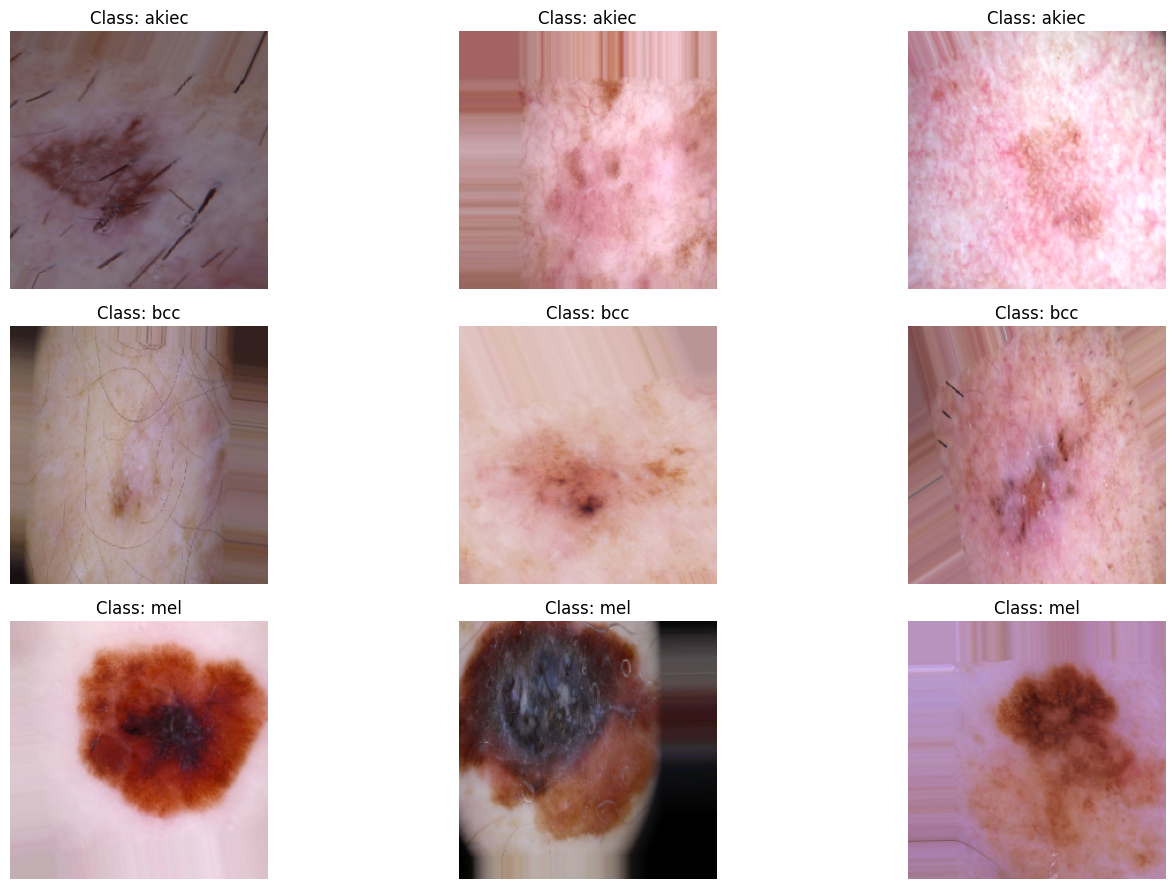

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Baca dataframes yang sudah disimpan
train_df = pd.read_csv('/content/train_df.csv')
val_df = pd.read_csv('/content/val_df.csv')

# Pastikan semua path gambar adalah string
print(f"All image paths are strings: {all(train_df['image_path'].apply(lambda x: isinstance(x, str)))}")

# Verifikasi bahwa semua file gambar ada
missing_files_train = train_df[~train_df['image_path'].apply(os.path.exists)]
missing_files_val = val_df[~val_df['image_path'].apply(os.path.exists)]

if len(missing_files_train) > 0:
    print(f"WARNING: {len(missing_files_train)} missing image files in training set")
    train_df = train_df[train_df['image_path'].apply(os.path.exists)]

if len(missing_files_val) > 0:
    print(f"WARNING: {len(missing_files_val)} missing image files in validation set")
    val_df = val_df[val_df['image_path'].apply(os.path.exists)]

# Data Generators
print("\nMengkonfigurasi data generators dengan augmentasi...")

# Augmentasi untuk train set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    brightness_range=[0.7, 1.3],
    channel_shift_range=0.15
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Generator untuk train dan validation
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='dx',
    class_mode='categorical',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='image_path',
    y_col='dx',
    class_mode='categorical',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Tampilkan pemetaan kelas ke indeks
class_indices = train_generator.class_indices
class_indices_reversed = {v: k for k, v in class_indices.items()}
print("Class indices:", class_indices)

# Cetak ukuran input dari generator untuk verifikasi
print(f"Ukuran input dari train_generator: {train_generator.image_shape}")
print(f"Jumlah kelas dari generator: {len(class_indices)}")

# Siapkan custom_objects untuk load model
custom_objects = {
    'CBAM': CBAM,
    'ChannelAttention': ChannelAttention,
    'SpatialAttention': SpatialAttention,
    'CastLayer': CastLayer
}

# Visualisasi beberapa contoh gambar dari setiap kelas setelah augmentasi
def plot_augmented_images(generator, class_indices_reversed, num_images=3):
    """Menampilkan contoh gambar yang telah diaugmentasi untuk setiap kelas"""
    plt.figure(figsize=(15, len(class_indices_reversed) * 3))

    for i, class_idx in enumerate(range(len(class_indices_reversed))):
        class_name = class_indices_reversed[class_idx]
        # Ambil gambar dari kelas ini
        images_of_class = []
        labels_of_class = []

        # Batasi iterasi untuk menghindari loop tak terbatas
        max_iterations = 100
        for _ in range(max_iterations):
            try:
                x_batch, y_batch = next(generator)
                for img, label in zip(x_batch, y_batch):
                    if np.argmax(label) == class_idx and len(images_of_class) < num_images:
                        images_of_class.append(img)
                        labels_of_class.append(label)
                if len(images_of_class) >= num_images:
                    break
            except StopIteration:
                generator.reset()
                if len(images_of_class) == 0:
                    break

        # Plot gambar
        for j, img in enumerate(images_of_class):
            if j < num_images:  # Pastikan hanya menampilkan jumlah gambar yang diminta
                plt.subplot(len(class_indices_reversed), num_images, i * num_images + j + 1)
                plt.imshow(img)
                plt.title(f'Class: {class_name}')
                plt.axis('off')

    plt.tight_layout()
    plt.show()

# Buat generator khusus untuk visualisasi
viz_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='dx',
    class_mode='categorical',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=100  # Seed berbeda untuk variasi
)

print("Menampilkan contoh gambar yang diaugmentasi:")
plot_augmented_images(viz_generator, class_indices_reversed, num_images=3)

# Bagian 6: Model VGG16 dengan CBAM

Menggunakan ukuran input: (224, 224, 3)

Membuat model VGG16 dengan CBAM dan Progressive Learning...
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "VGG16_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vgg16 (Functional)        │ (None, 7, 7, 512)      │     14,714,688 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cbam (CBAM)               │ (None, 7, 7, 512)      │         66,211 │ vgg16[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling2d_2    │ (None, 512)            │              0 │ cbam[0][0]             │
│ (GlobalMaxPooling2D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 512)            │              0 │ cbam[0][0]             │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 1024)           │              0 │ global_max_pooling2d_… │
│ (Concatenate)             │                        │                │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 1024)           │          4,096 │ concatenate_2[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 512)            │        524,800 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 512)            │          2,048 │ dense_2[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 512)            │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 256)            │        131,328 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 256)            │          1,024 │ dense_3[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 256)            │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 3)              │            771 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 15,444,966 (58.92 MB)

 Trainable params: 13,705,894 (52.28 MB)

 Non-trainable params: 1,739,072 (6.63 MB)


Training model VGG16...
Epoch 1/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.3782 - loss: 2.3766
Epoch 1: val_accuracy improved from -inf to 0.33542, saving model to best_VGG16.h5


120/120 ━━━━━━━━━━━━━━━━━━━━ 89s 462ms/step - accuracy: 0.3785 - loss: 2.3756 - val_accuracy: 0.3354 - val_loss: 5.8933 - learning_rate: 1.0000e-04
Epoch 2/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.4672 - loss: 2.0640
Epoch 2: val_accuracy did not improve from 0.33542
120/120 ━━━━━━━━━━━━━━━━━━━━ 100s 343ms/step - accuracy: 0.4670 - loss: 2.0645 - val_accuracy: 0.3354 - val_loss: 5.0379 - learning_rate: 1.0000e-04
Epoch 3/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.4946 - loss: 1.9745
Epoch 3: val_accuracy improved from 0.33542 to 0.47292, saving model to best_VGG16.h5


120/120 ━━━━━━━━━━━━━━━━━━━━ 43s 356ms/step - accuracy: 0.4947 - loss: 1.9739 - val_accuracy: 0.4729 - val_loss: 2.2228 - learning_rate: 1.0000e-04
Epoch 4/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.5226 - loss: 1.7873
Epoch 4: val_accuracy improved from 0.47292 to 0.47500, saving model to best_VGG16.h5


120/120 ━━━━━━━━━━━━━━━━━━━━ 40s 336ms/step - accuracy: 0.5226 - loss: 1.7873 - val_accuracy: 0.4750 - val_loss: 2.3973 - learning_rate: 1.0000e-04
Epoch 5/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.5293 - loss: 1.7989
Epoch 5: val_accuracy did not improve from 0.47500
120/120 ━━━━━━━━━━━━━━━━━━━━ 41s 338ms/step - accuracy: 0.5292 - loss: 1.7988 - val_accuracy: 0.3333 - val_loss: 11.2626 - learning_rate: 1.0000e-04
Epoch 6/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.5311 - loss: 1.7264
Epoch 6: val_accuracy did not improve from 0.47500
120/120 ━━━━━━━━━━━━━━━━━━━━ 42s 351ms/step - accuracy: 0.5313 - loss: 1.7263 - val_accuracy: 0.3333 - val_loss: 11.3215 - learning_rate: 1.0000e-04
Epoch 7/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - accuracy: 0.5100 - loss: 1.8250
Epoch 7: val_accuracy did not improve from 0.47500
120/120 ━━━━━━━━━━━━━━━━━━━━ 40s 335ms/step - accuracy: 0.5101 - loss: 1.8247 - val_accuracy: 0.3917 - val_loss: 6.9713 - learning_rat

120/120 ━━━━━━━━━━━━━━━━━━━━ 40s 337ms/step - accuracy: 0.5709 - loss: 1.6727 - val_accuracy: 0.5167 - val_loss: 1.8652 - learning_rate: 1.0000e-04
Epoch 9/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - accuracy: 0.5326 - loss: 1.7173
Epoch 9: val_accuracy improved from 0.51667 to 0.57500, saving model to best_VGG16.h5


120/120 ━━━━━━━━━━━━━━━━━━━━ 41s 338ms/step - accuracy: 0.5326 - loss: 1.7169 - val_accuracy: 0.5750 - val_loss: 2.8089 - learning_rate: 1.0000e-04
Epoch 10/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.5491 - loss: 1.6521
Epoch 10: val_accuracy did not improve from 0.57500
120/120 ━━━━━━━━━━━━━━━━━━━━ 42s 341ms/step - accuracy: 0.5491 - loss: 1.6519 - val_accuracy: 0.3333 - val_loss: 11.2891 - learning_rate: 1.0000e-04
Epoch 11/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.5362 - loss: 1.6579
Epoch 11: val_accuracy improved from 0.57500 to 0.58333, saving model to best_VGG16.h5


120/120 ━━━━━━━━━━━━━━━━━━━━ 41s 345ms/step - accuracy: 0.5362 - loss: 1.6577 - val_accuracy: 0.5833 - val_loss: 3.3949 - learning_rate: 1.0000e-04
Epoch 12/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.5641 - loss: 1.5635
Epoch 12: val_accuracy did not improve from 0.58333
120/120 ━━━━━━━━━━━━━━━━━━━━ 41s 343ms/step - accuracy: 0.5639 - loss: 1.5638 - val_accuracy: 0.3917 - val_loss: 7.0533 - learning_rate: 1.0000e-04
Epoch 13/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.5564 - loss: 1.6072
Epoch 13: val_accuracy did not improve from 0.58333
120/120 ━━━━━━━━━━━━━━━━━━━━ 41s 341ms/step - accuracy: 0.5563 - loss: 1.6072 - val_accuracy: 0.5625 - val_loss: 2.6571 - learning_rate: 1.0000e-04
Epoch 14/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.5482 - loss: 1.5687
Epoch 14: val_accuracy improved from 0.58333 to 0.60625, saving model to best_VGG16.h5


120/120 ━━━━━━━━━━━━━━━━━━━━ 41s 344ms/step - accuracy: 0.5483 - loss: 1.5687 - val_accuracy: 0.6062 - val_loss: 1.5464 - learning_rate: 1.0000e-04
Epoch 15/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - accuracy: 0.5983 - loss: 1.4668
Epoch 15: val_accuracy did not improve from 0.60625
120/120 ━━━━━━━━━━━━━━━━━━━━ 41s 342ms/step - accuracy: 0.5982 - loss: 1.4670 - val_accuracy: 0.3333 - val_loss: 6.6182 - learning_rate: 1.0000e-04
Epoch 16/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.5948 - loss: 1.5115
Epoch 16: val_accuracy did not improve from 0.60625
120/120 ━━━━━━━━━━━━━━━━━━━━ 42s 348ms/step - accuracy: 0.5948 - loss: 1.5116 - val_accuracy: 0.5125 - val_loss: 2.1605 - learning_rate: 1.0000e-04
Epoch 17/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - accuracy: 0.5964 - loss: 1.4713
Epoch 17: val_accuracy did not improve from 0.60625
120/120 ━━━━━━━━━━━━━━━━━━━━ 80s 335ms/step - accuracy: 0.5965 - loss: 1.4712 - val_accuracy: 0.4292 - val_loss: 2.6428 - learning

120/120 ━━━━━━━━━━━━━━━━━━━━ 42s 349ms/step - accuracy: 0.6155 - loss: 1.4415 - val_accuracy: 0.6500 - val_loss: 1.4847 - learning_rate: 1.0000e-04
Epoch 19/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - accuracy: 0.6070 - loss: 1.4327
Epoch 19: val_accuracy did not improve from 0.65000
120/120 ━━━━━━━━━━━━━━━━━━━━ 81s 343ms/step - accuracy: 0.6073 - loss: 1.4322 - val_accuracy: 0.6083 - val_loss: 2.1747 - learning_rate: 1.0000e-04
Epoch 20/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - accuracy: 0.6396 - loss: 1.3539
Epoch 20: val_accuracy improved from 0.65000 to 0.75417, saving model to best_VGG16.h5


120/120 ━━━━━━━━━━━━━━━━━━━━ 82s 344ms/step - accuracy: 0.6397 - loss: 1.3538 - val_accuracy: 0.7542 - val_loss: 1.1072 - learning_rate: 1.0000e-04
Epoch 21/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - accuracy: 0.6843 - loss: 1.3042
Epoch 21: val_accuracy did not improve from 0.75417
120/120 ━━━━━━━━━━━━━━━━━━━━ 41s 345ms/step - accuracy: 0.6843 - loss: 1.3042 - val_accuracy: 0.6021 - val_loss: 1.3270 - learning_rate: 1.0000e-04
Epoch 22/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.6714 - loss: 1.2865
Epoch 22: val_accuracy did not improve from 0.75417
120/120 ━━━━━━━━━━━━━━━━━━━━ 40s 336ms/step - accuracy: 0.6714 - loss: 1.2866 - val_accuracy: 0.4083 - val_loss: 3.1173 - learning_rate: 1.0000e-04
Epoch 23/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - accuracy: 0.6845 - loss: 1.2811
Epoch 23: val_accuracy did not improve from 0.75417
120/120 ━━━━━━━━━━━━━━━━━━━━ 41s 340ms/step - accuracy: 0.6845 - loss: 1.2810 - val_accuracy: 0.4917 - val_loss: 2.1841 - learning

120/120 ━━━━━━━━━━━━━━━━━━━━ 43s 362ms/step - accuracy: 0.7243 - loss: 1.1346 - val_accuracy: 0.7750 - val_loss: 1.0402 - learning_rate: 1.0000e-05
Epoch 32/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.7396 - loss: 1.1464
Epoch 32: val_accuracy did not improve from 0.77500
120/120 ━━━━━━━━━━━━━━━━━━━━ 41s 339ms/step - accuracy: 0.7396 - loss: 1.1463 - val_accuracy: 0.6333 - val_loss: 1.4393 - learning_rate: 1.0000e-05
Epoch 33/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - accuracy: 0.7248 - loss: 1.1145
Epoch 33: val_accuracy improved from 0.77500 to 0.80417, saving model to best_VGG16.h5


120/120 ━━━━━━━━━━━━━━━━━━━━ 41s 345ms/step - accuracy: 0.7248 - loss: 1.1144 - val_accuracy: 0.8042 - val_loss: 0.9474 - learning_rate: 1.0000e-05
Epoch 34/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - accuracy: 0.7395 - loss: 1.1118
Epoch 34: val_accuracy did not improve from 0.80417
120/120 ━━━━━━━━━━━━━━━━━━━━ 42s 348ms/step - accuracy: 0.7395 - loss: 1.1119 - val_accuracy: 0.7667 - val_loss: 1.0098 - learning_rate: 1.0000e-05
Epoch 35/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.7362 - loss: 1.0958
Epoch 35: val_accuracy did not improve from 0.80417
120/120 ━━━━━━━━━━━━━━━━━━━━ 41s 341ms/step - accuracy: 0.7362 - loss: 1.0959 - val_accuracy: 0.7375 - val_loss: 1.0362 - learning_rate: 1.0000e-05
Epoch 36/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.7448 - loss: 1.0815
Epoch 36: val_accuracy improved from 0.80417 to 0.81042, saving model to best_VGG16.h5


120/120 ━━━━━━━━━━━━━━━━━━━━ 42s 347ms/step - accuracy: 0.7447 - loss: 1.0816 - val_accuracy: 0.8104 - val_loss: 0.9577 - learning_rate: 1.0000e-05
Epoch 37/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - accuracy: 0.7461 - loss: 1.0791
Epoch 37: val_accuracy did not improve from 0.81042
120/120 ━━━━━━━━━━━━━━━━━━━━ 42s 350ms/step - accuracy: 0.7461 - loss: 1.0792 - val_accuracy: 0.6771 - val_loss: 1.2866 - learning_rate: 1.0000e-05
Epoch 38/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.7499 - loss: 1.1018
Epoch 38: val_accuracy improved from 0.81042 to 0.82500, saving model to best_VGG16.h5


120/120 ━━━━━━━━━━━━━━━━━━━━ 42s 347ms/step - accuracy: 0.7500 - loss: 1.1017 - val_accuracy: 0.8250 - val_loss: 0.9131 - learning_rate: 1.0000e-05
Epoch 39/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.7723 - loss: 1.0434
Epoch 39: val_accuracy did not improve from 0.82500
120/120 ━━━━━━━━━━━━━━━━━━━━ 43s 359ms/step - accuracy: 0.7722 - loss: 1.0435 - val_accuracy: 0.7771 - val_loss: 1.0025 - learning_rate: 1.0000e-05
Epoch 40/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - accuracy: 0.7565 - loss: 1.0696
Epoch 40: val_accuracy did not improve from 0.82500
120/120 ━━━━━━━━━━━━━━━━━━━━ 80s 339ms/step - accuracy: 0.7564 - loss: 1.0698 - val_accuracy: 0.6750 - val_loss: 1.4178 - learning_rate: 1.0000e-05
Epoch 41/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - accuracy: 0.7398 - loss: 1.1317
Epoch 41: val_accuracy did not improve from 0.82500
120/120 ━━━━━━━━━━━━━━━━━━━━ 41s 340ms/step - accuracy: 0.7399 - loss: 1.1315 - val_accuracy: 0.7937 - val_loss: 0.9385 - learning

120/120 ━━━━━━━━━━━━━━━━━━━━ 42s 354ms/step - accuracy: 0.7812 - loss: 1.0010 - val_accuracy: 0.8375 - val_loss: 0.8732 - learning_rate: 1.0000e-05
Epoch 57/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.7787 - loss: 0.9974
Epoch 57: val_accuracy did not improve from 0.83750
120/120 ━━━━━━━━━━━━━━━━━━━━ 41s 343ms/step - accuracy: 0.7787 - loss: 0.9974 - val_accuracy: 0.7958 - val_loss: 0.9144 - learning_rate: 1.0000e-05
Epoch 58/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - accuracy: 0.7862 - loss: 0.9724
Epoch 58: val_accuracy did not improve from 0.83750
120/120 ━━━━━━━━━━━━━━━━━━━━ 41s 338ms/step - accuracy: 0.7861 - loss: 0.9726 - val_accuracy: 0.7688 - val_loss: 0.9910 - learning_rate: 1.0000e-05
Epoch 59/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - accuracy: 0.7873 - loss: 0.9737
Epoch 59: val_accuracy did not improve from 0.83750
120/120 ━━━━━━━━━━━━━━━━━━━━ 42s 354ms/step - accuracy: 0.7871 - loss: 0.9739 - val_accuracy: 0.7708 - val_loss: 0.9944 - learning

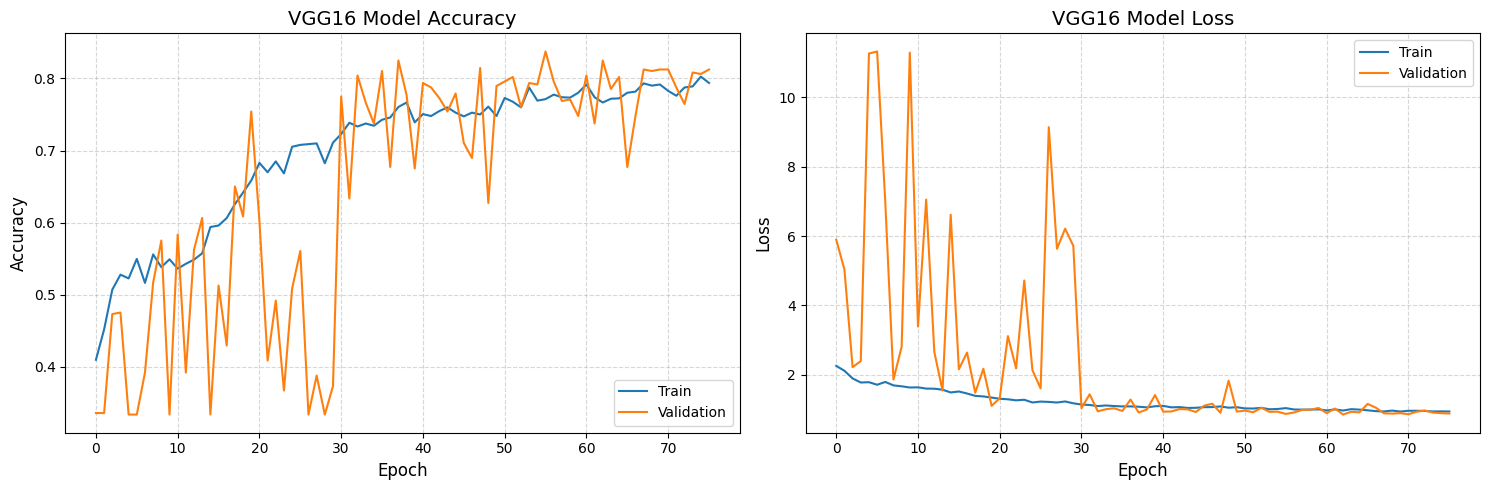


Evaluasi Model VGG16:
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step


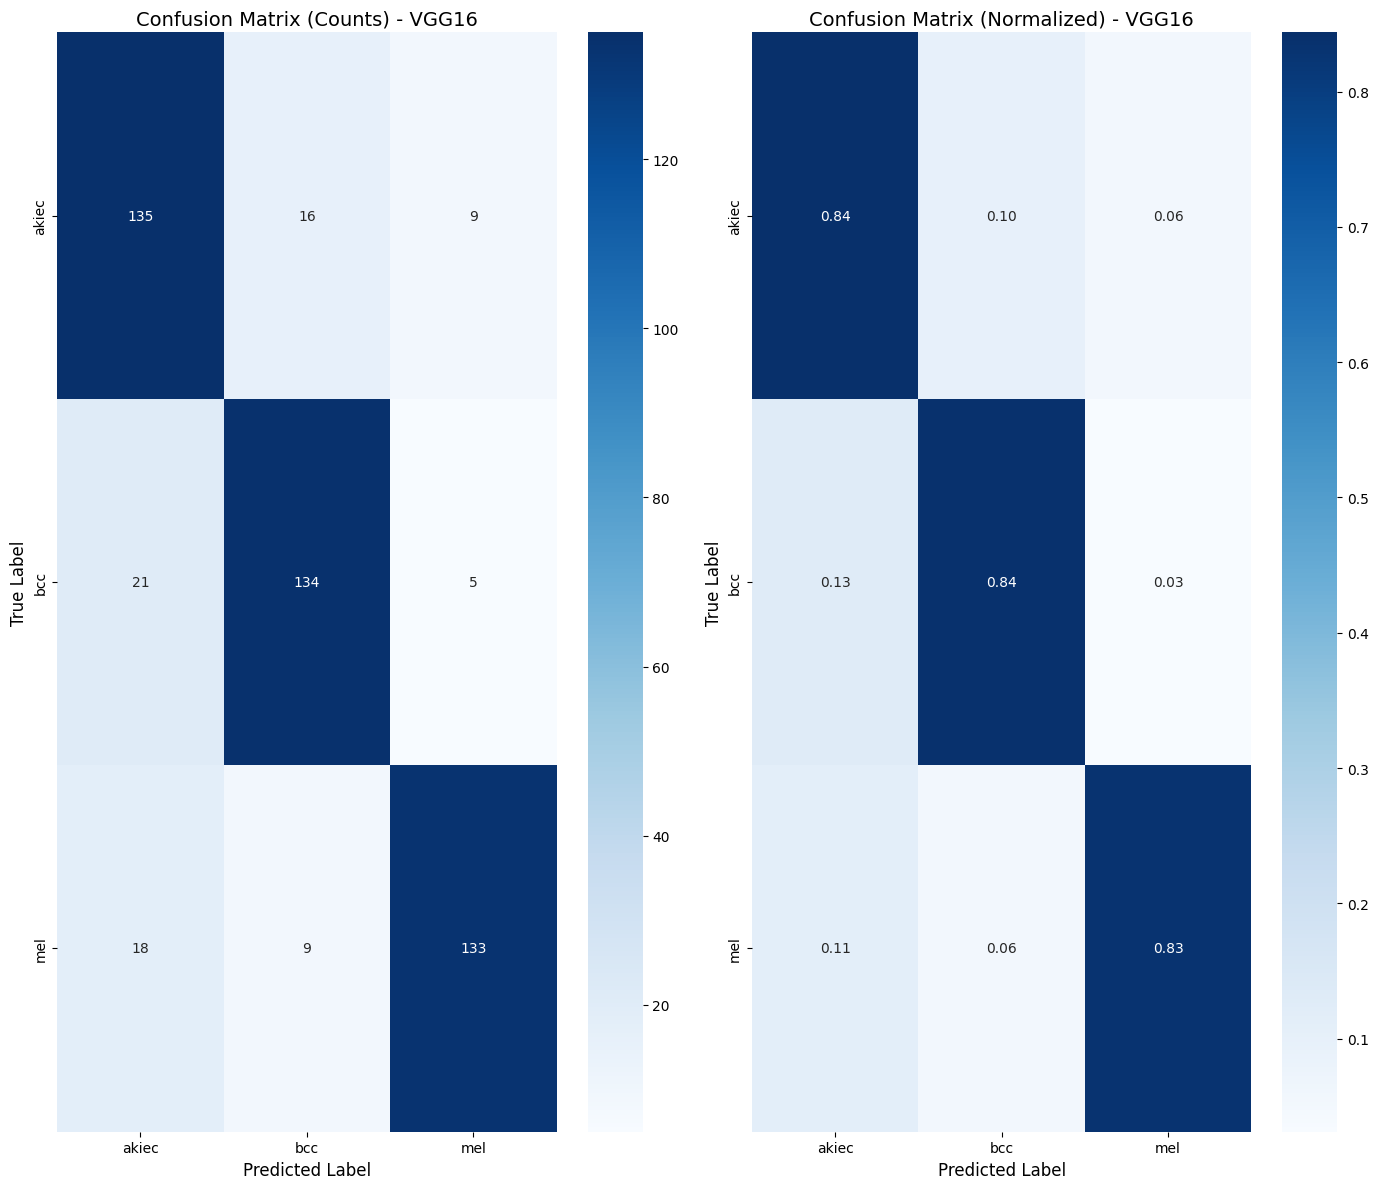


Classification Report - VGG16:
Accuracy: 0.8375

Per-Class Metrics:
Class akiec:
  Precision: 0.7759
  Recall: 0.8438
  F1-score: 0.8084
  Support: 160.0
Class bcc:
  Precision: 0.8428
  Recall: 0.8375
  F1-score: 0.8401
  Support: 160.0
Class mel:
  Precision: 0.9048
  Recall: 0.8313
  F1-score: 0.8664
  Support: 160.0

Average Metrics:
  Macro Avg Precision: 0.8411
  Macro Avg Recall: 0.8375
  Macro Avg F1-score: 0.8383
  Weighted Avg Precision: 0.8411
  Weighted Avg Recall: 0.8375
  Weighted Avg F1-score: 0.8383


<Figure size 1400x800 with 0 Axes>

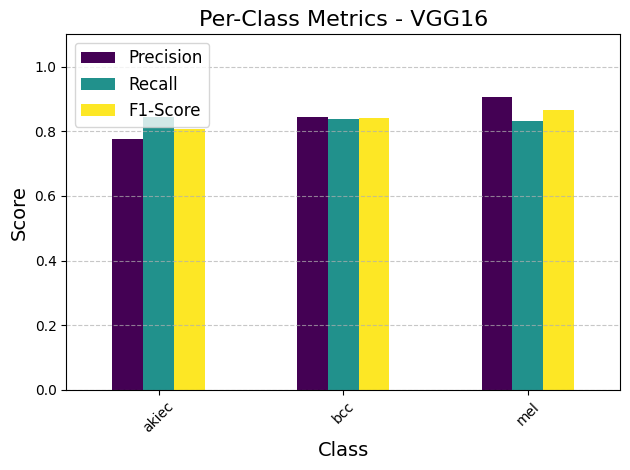

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Concatenate
from tensorflow.keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import load_model

# Sesuaikan ukuran input model dengan ukuran dari generator
img_shape = (IMG_SIZE, IMG_SIZE, 3)
print(f"Menggunakan ukuran input: {img_shape}")

# ----- MODEL 1: VGG16 dengan CBAM dan Progressive Learning -----
print("\nMembuat model VGG16 dengan CBAM dan Progressive Learning...")
try:
    # Inisialisasi base model VGG16
    vgg16_base = VGG16(
        include_top=False,
        input_shape=img_shape,
        weights='imagenet'
    )

    # Progressive unfreezing - hanya tiga blok terakhir yang dilatih
    for layer in vgg16_base.layers[:-8]:  # Bekukan semua layer kecuali 8 terakhir
        layer.trainable = False

    # Menerapkan CBAM pada VGG16
    vgg16_input = Input(shape=img_shape)
    x = vgg16_base(vgg16_input)

    # Tambahkan CBAM di akhir base model
    cbam = CBAM(ratio=8, kernel_size=7)
    x = cbam(x)

    # Global pooling dengan kombinasi max dan avg untuk informasi yang lebih kaya
    max_pool = GlobalMaxPooling2D()(x)
    avg_pool = GlobalAveragePooling2D()(x)
    x = Concatenate()([max_pool, avg_pool])

    # Classifier dengan dropout dan batch normalization
    x = BatchNormalization()(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.0005))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.0005))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    vgg16_output = Dense(len(class_indices), activation='softmax')(x)

    vgg16_model = Model(inputs=vgg16_input, outputs=vgg16_output, name='VGG16_Model')

    vgg16_model.summary()

    # Kompilasi model VGG16 dengan optimizer yang lebih baik
    vgg16_model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Train model VGG16
    print("\nTraining model VGG16...")
    vgg16_history, vgg16_time = train_with_time(
        vgg16_model,
        train_generator,
        val_generator,
        EPOCHS,
        get_callbacks('VGG16'),
        "VGG16"
    )

    # Coba load model dengan strategi yang berbeda
    try:
        # Coba dengan custom_objects yang lengkap
        best_vgg16 = load_model('best_VGG16.h5', custom_objects=custom_objects)
    except:
        try:
            # Jika gagal, coba dengan scope
            with tf.keras.utils.custom_object_scope(custom_objects):
                best_vgg16 = load_model('best_VGG16.h5')
        except:
            # Jika masih gagal, gunakan model dari hasil training
            print("Tidak dapat memuat model tersimpan. Menggunakan model dari hasil training.")
            best_vgg16 = vgg16_model

    # Visualisasi hasil training VGG16
    if vgg16_history is not None:
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 2, 1)
        plt.plot(vgg16_history.history['accuracy'])
        plt.plot(vgg16_history.history['val_accuracy'])
        plt.title('VGG16 Model Accuracy', size=14)
        plt.ylabel('Accuracy', size=12)
        plt.xlabel('Epoch', size=12)
        plt.legend(['Train', 'Validation'], loc='lower right')
        plt.grid(True, linestyle='--', alpha=0.5)

        plt.subplot(1, 2, 2)
        plt.plot(vgg16_history.history['loss'])
        plt.plot(vgg16_history.history['val_loss'])
        plt.title('VGG16 Model Loss', size=14)
        plt.ylabel('Loss', size=12)
        plt.xlabel('Epoch', size=12)
        plt.legend(['Train', 'Validation'], loc='upper right')
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

    # Evaluasi VGG16
    vgg16_report, vgg16_cm, vgg16_metrics_df = evaluate_model(best_vgg16, val_generator, "VGG16")

    # Simpan hasil untuk perbandingan
    import pickle
    with open('vgg16_results.pkl', 'wb') as f:
        pickle.dump({
            'history': vgg16_history.history if vgg16_history else None,
            'time': vgg16_time,
            'report': vgg16_report,
            'metrics_df': vgg16_metrics_df
        }, f)

except Exception as e:
    import traceback
    print(f"Error saat membuat model VGG16: {e}")
    traceback.print_exc()

# Bagian 7: Model MobileNet dengan CBAM


Membuat model MobileNetV2 dengan CBAM...
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "MobileNetV2_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mobilenetv2_1.00_224      │ (None, 7, 7, 1280)     │      2,257,984 │ input_layer_3[0][0]    │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cbam_1 (CBAM)             │ (None, 7, 7, 1280)     │        411,139 │ mobilenetv2_1.00_224[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling2d_9    │ (None, 1280)           │              0 │ cbam_1[0][0]           │
│ (GlobalMaxPooling2D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 1280)           │              0 │ cbam_1[0][0]           │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_9             │ (None, 2560)           │              0 │ global_max_pooling2d_… │
│ (Concatenate)             │                        │                │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 2560)           │         10,240 │ concatenate_9[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 512)            │      1,311,232 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 512)            │          2,048 │ dense_7[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 512)            │              0 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 256)            │        131,328 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 256)            │          1,024 │ dense_8[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 256)            │              0 │ batch_normalization_5… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 3)              │            771 │ dropout_3[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 4,125,766 (15.74 MB)

 Trainable params: 3,067,206 (11.70 MB)

 Non-trainable params: 1,058,560 (4.04 MB)


Training model MobileNetV2...
Epoch 1/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.4000 - loss: 2.5157
Epoch 1: val_accuracy improved from -inf to 0.48333, saving model to best_MobileNetV2.h5


120/120 ━━━━━━━━━━━━━━━━━━━━ 69s 363ms/step - accuracy: 0.4003 - loss: 2.5149 - val_accuracy: 0.4833 - val_loss: 1.9627 - learning_rate: 1.0000e-04
Epoch 2/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.5275 - loss: 2.1795
Epoch 2: val_accuracy improved from 0.48333 to 0.54583, saving model to best_MobileNetV2.h5


120/120 ━━━━━━━━━━━━━━━━━━━━ 38s 319ms/step - accuracy: 0.5274 - loss: 2.1795 - val_accuracy: 0.5458 - val_loss: 1.9343 - learning_rate: 1.0000e-04
Epoch 3/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.5577 - loss: 2.0799
Epoch 3: val_accuracy improved from 0.54583 to 0.57292, saving model to best_MobileNetV2.h5


120/120 ━━━━━━━━━━━━━━━━━━━━ 41s 318ms/step - accuracy: 0.5579 - loss: 2.0795 - val_accuracy: 0.5729 - val_loss: 1.8759 - learning_rate: 1.0000e-04
Epoch 4/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.5910 - loss: 1.9716
Epoch 4: val_accuracy improved from 0.57292 to 0.60833, saving model to best_MobileNetV2.h5


120/120 ━━━━━━━━━━━━━━━━━━━━ 38s 317ms/step - accuracy: 0.5910 - loss: 1.9717 - val_accuracy: 0.6083 - val_loss: 1.9561 - learning_rate: 1.0000e-04
Epoch 5/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.6278 - loss: 1.9112
Epoch 5: val_accuracy improved from 0.60833 to 0.66250, saving model to best_MobileNetV2.h5


120/120 ━━━━━━━━━━━━━━━━━━━━ 38s 317ms/step - accuracy: 0.6277 - loss: 1.9112 - val_accuracy: 0.6625 - val_loss: 1.9092 - learning_rate: 1.0000e-04
Epoch 6/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.6395 - loss: 1.7802
Epoch 6: val_accuracy did not improve from 0.66250
120/120 ━━━━━━━━━━━━━━━━━━━━ 37s 312ms/step - accuracy: 0.6396 - loss: 1.7803 - val_accuracy: 0.6458 - val_loss: 1.9403 - learning_rate: 1.0000e-04
Epoch 7/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.6284 - loss: 1.8359
Epoch 7: val_accuracy did not improve from 0.66250
120/120 ━━━━━━━━━━━━━━━━━━━━ 38s 315ms/step - accuracy: 0.6285 - loss: 1.8356 - val_accuracy: 0.6375 - val_loss: 2.0525 - learning_rate: 1.0000e-04
Epoch 8/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.6800 - loss: 1.6764
Epoch 8: val_accuracy did not improve from 0.66250
120/120 ━━━━━━━━━━━━━━━━━━━━ 38s 316ms/step - accuracy: 0.6799 - loss: 1.6769 - val_accuracy: 0.6271 - val_loss: 2.0505 - learning_rate:

120/120 ━━━━━━━━━━━━━━━━━━━━ 38s 318ms/step - accuracy: 0.6950 - loss: 1.6811 - val_accuracy: 0.6833 - val_loss: 1.9041 - learning_rate: 1.0000e-04
Epoch 11/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.7050 - loss: 1.6338
Epoch 11: val_accuracy did not improve from 0.68333
120/120 ━━━━━━━━━━━━━━━━━━━━ 38s 315ms/step - accuracy: 0.7050 - loss: 1.6340 - val_accuracy: 0.5979 - val_loss: 2.2383 - learning_rate: 1.0000e-04
Epoch 12/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 0.6927 - loss: 1.6326
Epoch 12: val_accuracy improved from 0.68333 to 0.70208, saving model to best_MobileNetV2.h5


120/120 ━━━━━━━━━━━━━━━━━━━━ 41s 318ms/step - accuracy: 0.6927 - loss: 1.6329 - val_accuracy: 0.7021 - val_loss: 1.7177 - learning_rate: 1.0000e-04
Epoch 13/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.7122 - loss: 1.5872
Epoch 13: val_accuracy improved from 0.70208 to 0.70417, saving model to best_MobileNetV2.h5


120/120 ━━━━━━━━━━━━━━━━━━━━ 38s 320ms/step - accuracy: 0.7121 - loss: 1.5873 - val_accuracy: 0.7042 - val_loss: 1.7552 - learning_rate: 1.0000e-04
Epoch 14/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.7346 - loss: 1.5736
Epoch 14: val_accuracy improved from 0.70417 to 0.70833, saving model to best_MobileNetV2.h5


120/120 ━━━━━━━━━━━━━━━━━━━━ 39s 321ms/step - accuracy: 0.7345 - loss: 1.5738 - val_accuracy: 0.7083 - val_loss: 1.7774 - learning_rate: 1.0000e-04
Epoch 15/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.7636 - loss: 1.4761
Epoch 15: val_accuracy did not improve from 0.70833
120/120 ━━━━━━━━━━━━━━━━━━━━ 38s 317ms/step - accuracy: 0.7634 - loss: 1.4765 - val_accuracy: 0.6479 - val_loss: 1.9727 - learning_rate: 1.0000e-04
Epoch 16/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.7361 - loss: 1.5221
Epoch 16: val_accuracy did not improve from 0.70833
120/120 ━━━━━━━━━━━━━━━━━━━━ 38s 318ms/step - accuracy: 0.7362 - loss: 1.5221 - val_accuracy: 0.6917 - val_loss: 1.7514 - learning_rate: 1.0000e-04
Epoch 17/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.7509 - loss: 1.5054
Epoch 17: val_accuracy improved from 0.70833 to 0.73542, saving model to best_MobileNetV2.h5


120/120 ━━━━━━━━━━━━━━━━━━━━ 39s 324ms/step - accuracy: 0.7508 - loss: 1.5053 - val_accuracy: 0.7354 - val_loss: 1.7464 - learning_rate: 1.0000e-04
Epoch 18/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.7506 - loss: 1.5265
Epoch 18: val_accuracy improved from 0.73542 to 0.74583, saving model to best_MobileNetV2.h5


120/120 ━━━━━━━━━━━━━━━━━━━━ 39s 322ms/step - accuracy: 0.7506 - loss: 1.5264 - val_accuracy: 0.7458 - val_loss: 1.6255 - learning_rate: 1.0000e-04
Epoch 19/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.7447 - loss: 1.4783
Epoch 19: val_accuracy did not improve from 0.74583
120/120 ━━━━━━━━━━━━━━━━━━━━ 38s 319ms/step - accuracy: 0.7447 - loss: 1.4783 - val_accuracy: 0.7125 - val_loss: 1.7092 - learning_rate: 1.0000e-04
Epoch 20/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.7583 - loss: 1.4455
Epoch 20: val_accuracy did not improve from 0.74583
120/120 ━━━━━━━━━━━━━━━━━━━━ 43s 336ms/step - accuracy: 0.7584 - loss: 1.4455 - val_accuracy: 0.7292 - val_loss: 1.6596 - learning_rate: 1.0000e-04
Epoch 21/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.7519 - loss: 1.4972
Epoch 21: val_accuracy did not improve from 0.74583
120/120 ━━━━━━━━━━━━━━━━━━━━ 38s 315ms/step - accuracy: 0.7520 - loss: 1.4968 - val_accuracy: 0.7063 - val_loss: 1.7488 - learning

120/120 ━━━━━━━━━━━━━━━━━━━━ 39s 321ms/step - accuracy: 0.7666 - loss: 1.4246 - val_accuracy: 0.8042 - val_loss: 1.3672 - learning_rate: 1.0000e-04
Epoch 25/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.8075 - loss: 1.3353
Epoch 25: val_accuracy did not improve from 0.80417
120/120 ━━━━━━━━━━━━━━━━━━━━ 38s 314ms/step - accuracy: 0.8074 - loss: 1.3355 - val_accuracy: 0.7688 - val_loss: 1.3925 - learning_rate: 1.0000e-04
Epoch 26/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.7954 - loss: 1.3564
Epoch 26: val_accuracy did not improve from 0.80417
120/120 ━━━━━━━━━━━━━━━━━━━━ 38s 315ms/step - accuracy: 0.7953 - loss: 1.3565 - val_accuracy: 0.8000 - val_loss: 1.3458 - learning_rate: 1.0000e-04
Epoch 27/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.7935 - loss: 1.3423
Epoch 27: val_accuracy did not improve from 0.80417
120/120 ━━━━━━━━━━━━━━━━━━━━ 38s 313ms/step - accuracy: 0.7935 - loss: 1.3423 - val_accuracy: 0.7854 - val_loss: 1.3989 - learning

120/120 ━━━━━━━━━━━━━━━━━━━━ 38s 317ms/step - accuracy: 0.8306 - loss: 1.2990 - val_accuracy: 0.8104 - val_loss: 1.3578 - learning_rate: 1.0000e-04
Epoch 30/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.8124 - loss: 1.3012
Epoch 30: val_accuracy did not improve from 0.81042
120/120 ━━━━━━━━━━━━━━━━━━━━ 38s 313ms/step - accuracy: 0.8124 - loss: 1.3012 - val_accuracy: 0.8000 - val_loss: 1.3247 - learning_rate: 1.0000e-04
Epoch 31/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.7933 - loss: 1.3115
Epoch 31: val_accuracy did not improve from 0.81042
120/120 ━━━━━━━━━━━━━━━━━━━━ 42s 322ms/step - accuracy: 0.7934 - loss: 1.3114 - val_accuracy: 0.7958 - val_loss: 1.3187 - learning_rate: 1.0000e-04
Epoch 32/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.8172 - loss: 1.2695
Epoch 32: val_accuracy did not improve from 0.81042
120/120 ━━━━━━━━━━━━━━━━━━━━ 38s 315ms/step - accuracy: 0.8172 - loss: 1.2695 - val_accuracy: 0.8062 - val_loss: 1.3347 - learning

120/120 ━━━━━━━━━━━━━━━━━━━━ 38s 319ms/step - accuracy: 0.8227 - loss: 1.2706 - val_accuracy: 0.8208 - val_loss: 1.2841 - learning_rate: 1.0000e-04
Epoch 34/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.8269 - loss: 1.2567
Epoch 34: val_accuracy did not improve from 0.82083
120/120 ━━━━━━━━━━━━━━━━━━━━ 37s 312ms/step - accuracy: 0.8269 - loss: 1.2569 - val_accuracy: 0.7604 - val_loss: 1.4969 - learning_rate: 1.0000e-04
Epoch 35/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.8388 - loss: 1.2153
Epoch 35: val_accuracy did not improve from 0.82083
120/120 ━━━━━━━━━━━━━━━━━━━━ 37s 312ms/step - accuracy: 0.8387 - loss: 1.2155 - val_accuracy: 0.7188 - val_loss: 1.6561 - learning_rate: 1.0000e-04
Epoch 36/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.8418 - loss: 1.1935
Epoch 36: val_accuracy did not improve from 0.82083
120/120 ━━━━━━━━━━━━━━━━━━━━ 37s 311ms/step - accuracy: 0.8417 - loss: 1.1937 - val_accuracy: 0.7521 - val_loss: 1.5786 - learning

120/120 ━━━━━━━━━━━━━━━━━━━━ 38s 317ms/step - accuracy: 0.8334 - loss: 1.2078 - val_accuracy: 0.8458 - val_loss: 1.1971 - learning_rate: 1.0000e-04
Epoch 39/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.8540 - loss: 1.1781
Epoch 39: val_accuracy did not improve from 0.84583
120/120 ━━━━━━━━━━━━━━━━━━━━ 38s 317ms/step - accuracy: 0.8540 - loss: 1.1780 - val_accuracy: 0.8125 - val_loss: 1.2624 - learning_rate: 1.0000e-04
Epoch 40/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.8491 - loss: 1.1576
Epoch 40: val_accuracy improved from 0.84583 to 0.84792, saving model to best_MobileNetV2.h5


120/120 ━━━━━━━━━━━━━━━━━━━━ 38s 318ms/step - accuracy: 0.8491 - loss: 1.1579 - val_accuracy: 0.8479 - val_loss: 1.2176 - learning_rate: 1.0000e-04
Epoch 41/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.8296 - loss: 1.1883
Epoch 41: val_accuracy did not improve from 0.84792
120/120 ━━━━━━━━━━━━━━━━━━━━ 38s 316ms/step - accuracy: 0.8296 - loss: 1.1884 - val_accuracy: 0.7958 - val_loss: 1.3581 - learning_rate: 1.0000e-04
Epoch 42/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.8481 - loss: 1.1640
Epoch 42: val_accuracy did not improve from 0.84792
120/120 ━━━━━━━━━━━━━━━━━━━━ 38s 313ms/step - accuracy: 0.8480 - loss: 1.1641 - val_accuracy: 0.8000 - val_loss: 1.3235 - learning_rate: 1.0000e-04
Epoch 43/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.8554 - loss: 1.1454
Epoch 43: val_accuracy improved from 0.84792 to 0.85833, saving model to best_MobileNetV2.h5


120/120 ━━━━━━━━━━━━━━━━━━━━ 38s 318ms/step - accuracy: 0.8554 - loss: 1.1455 - val_accuracy: 0.8583 - val_loss: 1.2114 - learning_rate: 1.0000e-04
Epoch 44/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.8588 - loss: 1.1059
Epoch 44: val_accuracy did not improve from 0.85833
120/120 ━━━━━━━━━━━━━━━━━━━━ 40s 311ms/step - accuracy: 0.8588 - loss: 1.1059 - val_accuracy: 0.8188 - val_loss: 1.2594 - learning_rate: 1.0000e-04
Epoch 45/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.8698 - loss: 1.0860
Epoch 45: val_accuracy did not improve from 0.85833
120/120 ━━━━━━━━━━━━━━━━━━━━ 38s 314ms/step - accuracy: 0.8697 - loss: 1.0861 - val_accuracy: 0.8208 - val_loss: 1.2426 - learning_rate: 1.0000e-04
Epoch 46/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 0.8588 - loss: 1.1224
Epoch 46: val_accuracy did not improve from 0.85833
120/120 ━━━━━━━━━━━━━━━━━━━━ 37s 310ms/step - accuracy: 0.8587 - loss: 1.1225 - val_accuracy: 0.8562 - val_loss: 1.1832 - learning

120/120 ━━━━━━━━━━━━━━━━━━━━ 38s 317ms/step - accuracy: 0.8644 - loss: 1.1127 - val_accuracy: 0.8896 - val_loss: 1.1027 - learning_rate: 1.0000e-04
Epoch 48/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.8415 - loss: 1.1494
Epoch 48: val_accuracy did not improve from 0.88958
120/120 ━━━━━━━━━━━━━━━━━━━━ 37s 311ms/step - accuracy: 0.8415 - loss: 1.1493 - val_accuracy: 0.8542 - val_loss: 1.1366 - learning_rate: 1.0000e-04
Epoch 49/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.8717 - loss: 1.0779
Epoch 49: val_accuracy did not improve from 0.88958
120/120 ━━━━━━━━━━━━━━━━━━━━ 37s 312ms/step - accuracy: 0.8717 - loss: 1.0779 - val_accuracy: 0.7812 - val_loss: 1.4213 - learning_rate: 1.0000e-04
Epoch 50/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.8416 - loss: 1.1097
Epoch 50: val_accuracy did not improve from 0.88958
120/120 ━━━━━━━━━━━━━━━━━━━━ 38s 313ms/step - accuracy: 0.8417 - loss: 1.1095 - val_accuracy: 0.8375 - val_loss: 1.2161 - learning

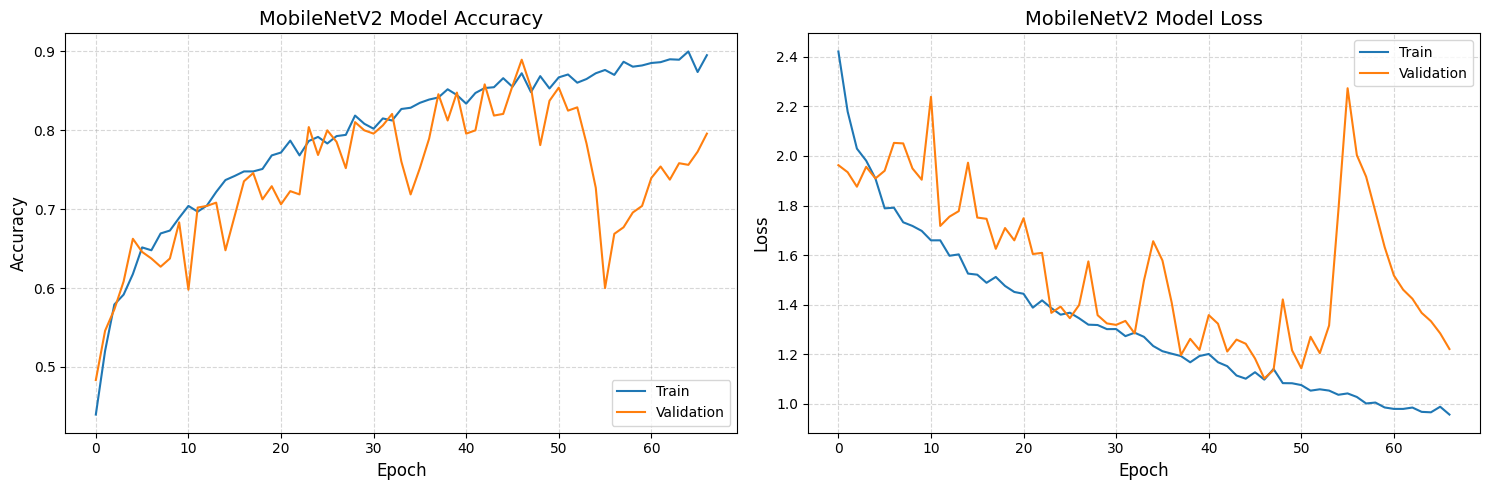


Evaluasi Model MobileNetV2:
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 111ms/step


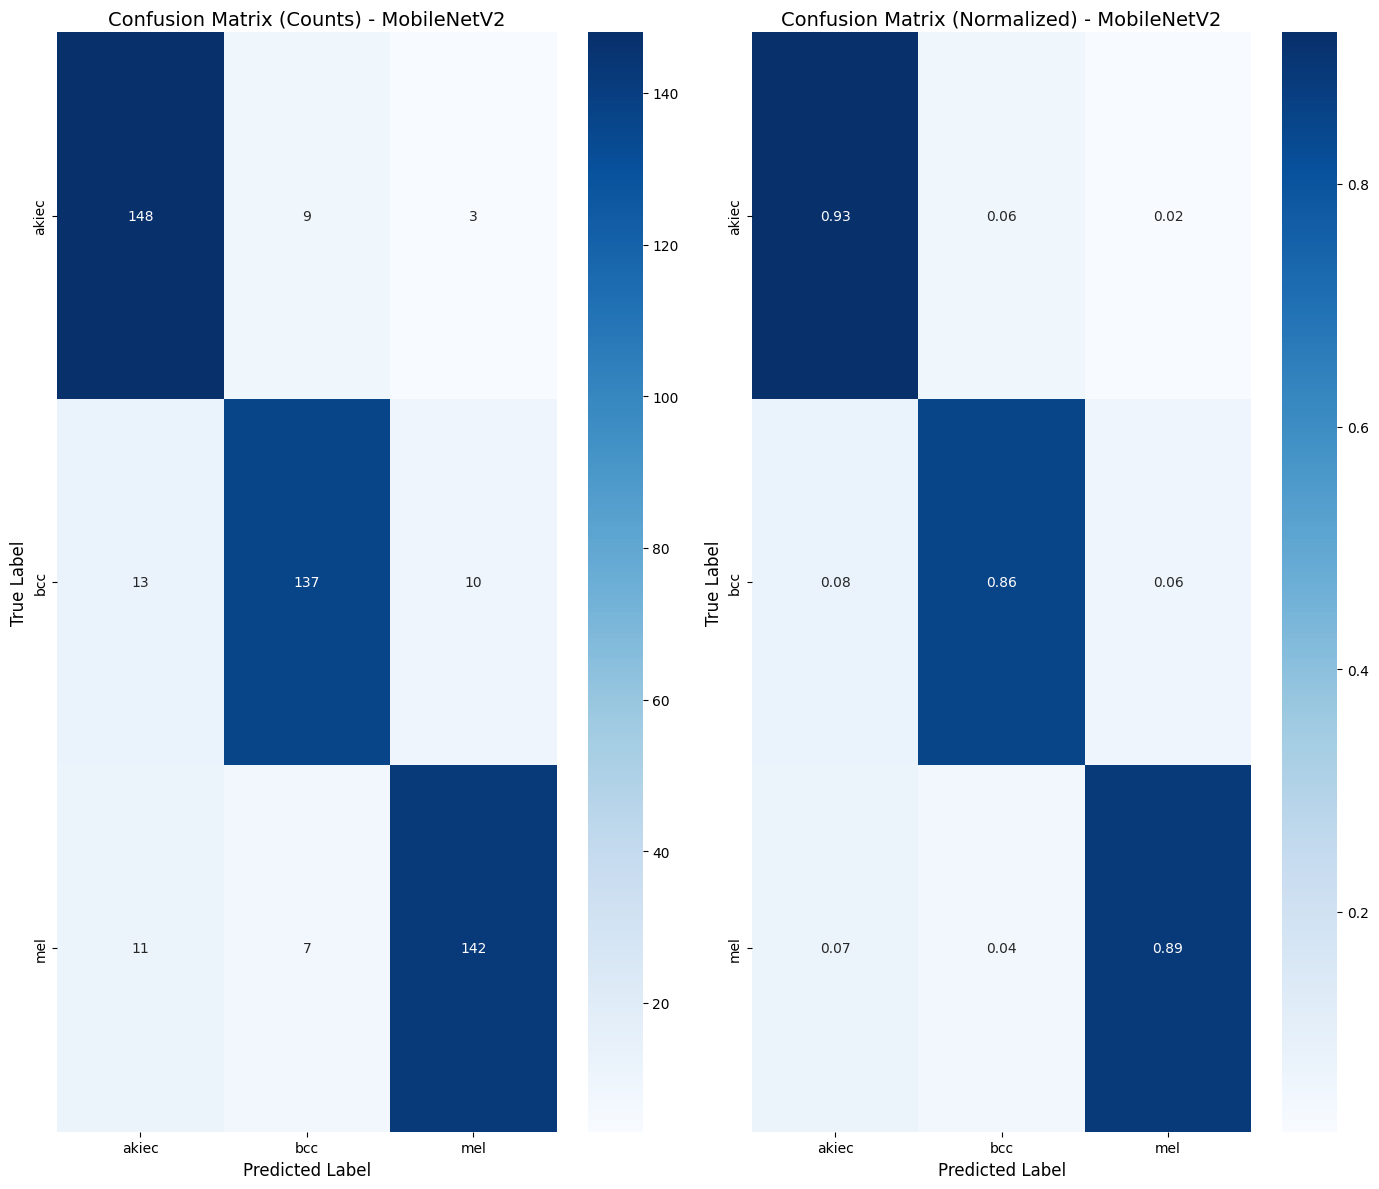


Classification Report - MobileNetV2:
Accuracy: 0.8896

Per-Class Metrics:
Class akiec:
  Precision: 0.8605
  Recall: 0.9250
  F1-score: 0.8916
  Support: 160.0
Class bcc:
  Precision: 0.8954
  Recall: 0.8562
  F1-score: 0.8754
  Support: 160.0
Class mel:
  Precision: 0.9161
  Recall: 0.8875
  F1-score: 0.9016
  Support: 160.0

Average Metrics:
  Macro Avg Precision: 0.8907
  Macro Avg Recall: 0.8896
  Macro Avg F1-score: 0.8895
  Weighted Avg Precision: 0.8907
  Weighted Avg Recall: 0.8896
  Weighted Avg F1-score: 0.8895


<Figure size 1400x800 with 0 Axes>

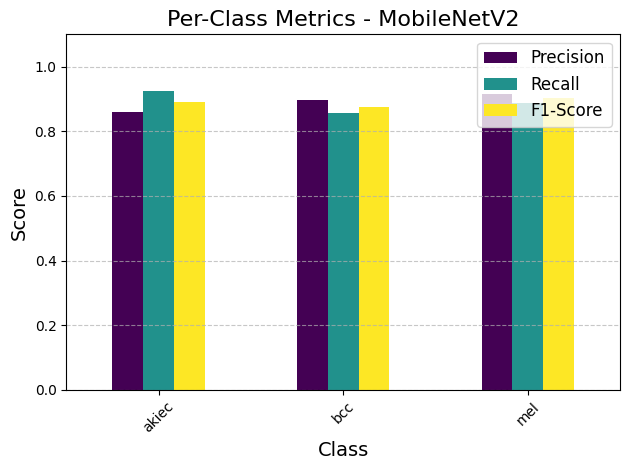

In [ ]:
from tensorflow.keras.applications import MobileNetV2

# ----- MODEL 2: MobileNetV2 dengan CBAM -----
print("\nMembuat model MobileNetV2 dengan CBAM...")
try:
    mobilenetv2_base = MobileNetV2(
        include_top=False,
        input_shape=img_shape,
        weights='imagenet'
    )

    # Progressive unfreezing - untuk MobileNetV2
    for layer in mobilenetv2_base.layers[:-20]:  # Bekukan semua layer kecuali 20 terakhir
        layer.trainable = False

    # Menerapkan CBAM pada MobileNetV2
    mobilenetv2_input = Input(shape=img_shape)
    x = mobilenetv2_base(mobilenetv2_input)

    # Tambahkan CBAM
    cbam_mobilenet = CBAM(ratio=8, kernel_size=7)
    x = cbam_mobilenet(x)

    # Global pooling dengan kombinasi max dan avg
    max_pool = GlobalMaxPooling2D()(x)
    avg_pool = GlobalAveragePooling2D()(x)
    x = Concatenate()([max_pool, avg_pool])

    # Classifier dengan dropout dan batch normalization yang dioptimasi
    x = BatchNormalization()(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.0005))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.0005))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    mobilenetv2_output = Dense(len(class_indices), activation='softmax')(x)

    mobilenetv2_model = Model(inputs=mobilenetv2_input, outputs=mobilenetv2_output, name='MobileNetV2_Model')

    mobilenetv2_model.summary()

    # Kompilasi model MobileNetV2
    mobilenetv2_model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Train model MobileNetV2
    print("\nTraining model MobileNetV2...")
    mobilenetv2_history, mobilenetv2_time = train_with_time(
        mobilenetv2_model,
        train_generator,
        val_generator,
        EPOCHS,
        get_callbacks('MobileNetV2'),
        "MobileNetV2"
    )

    # Load model terbaik
    try:
        best_mobilenetv2 = load_model('best_MobileNetV2.h5', custom_objects=custom_objects)
    except:
        try:
            # Jika gagal, coba dengan scope
            with tf.keras.utils.custom_object_scope(custom_objects):
                best_mobilenetv2 = load_model('best_MobileNetV2.h5')
        except:
            # Jika masih gagal, gunakan model dari hasil training
            print("Tidak dapat memuat model MobileNetV2 tersimpan. Menggunakan model dari hasil training.")
            best_mobilenetv2 = mobilenetv2_model

    # Visualisasi hasil training MobileNetV2
    if mobilenetv2_history is not None:
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 2, 1)
        plt.plot(mobilenetv2_history.history['accuracy'])
        plt.plot(mobilenetv2_history.history['val_accuracy'])
        plt.title('MobileNetV2 Model Accuracy', size=14)
        plt.ylabel('Accuracy', size=12)
        plt.xlabel('Epoch', size=12)
        plt.legend(['Train', 'Validation'], loc='lower right')
        plt.grid(True, linestyle='--', alpha=0.5)

        plt.subplot(1, 2, 2)
        plt.plot(mobilenetv2_history.history['loss'])
        plt.plot(mobilenetv2_history.history['val_loss'])
        plt.title('MobileNetV2 Model Loss', size=14)
        plt.ylabel('Loss', size=12)
        plt.xlabel('Epoch', size=12)
        plt.legend(['Train', 'Validation'], loc='upper right')
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

    # Evaluasi MobileNetV2
    mobilenetv2_report, mobilenetv2_cm, mobilenetv2_metrics_df = evaluate_model(best_mobilenetv2, val_generator, "MobileNetV2")

    # Simpan hasil untuk perbandingan
    import pickle
    with open('mobilenetv2_results.pkl', 'wb') as f:
        pickle.dump({
            'history': mobilenetv2_history.history if mobilenetv2_history else None,
            'time': mobilenetv2_time,
            'report': mobilenetv2_report,
            'metrics_df': mobilenetv2_metrics_df
        }, f)

except Exception as e:
    import traceback
    print(f"Error saat membuat model MobileNetV2: {e}")
    traceback.print_exc()

# Bagian 8: Model Gabungan VGG16 & MobileNet


Membuat Optimized Combined Model dengan attention mechanism...


Model: "Combined_VGG16_MobileNetV2_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ combined_input            │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vgg16 (Functional)        │ (None, 7, 7, 512)      │     14,714,688 │ combined_input[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mobilenetv2_1.00_224      │ (None, 7, 7, 1280)     │      2,257,984 │ combined_input[0][0]   │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cbam_2 (CBAM)             │ (None, 7, 7, 512)      │         66,211 │ vgg16[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cbam_3 (CBAM)             │ (None, 7, 7, 1280)     │        411,139 │ mobilenetv2_1.00_224[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling2d_18   │ (None, 512)            │              0 │ cbam_2[0][0]           │
│ (GlobalMaxPooling2D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 512)            │              0 │ cbam_2[0][0]           │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling2d_19   │ (None, 1280)           │              0 │ cbam_3[0][0]           │
│ (GlobalMaxPooling2D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 1280)           │              0 │ cbam_3[0][0]           │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_18            │ (None, 1024)           │              0 │ global_max_pooling2d_… │
│ (Concatenate)             │                        │                │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_19            │ (None, 2560)           │              0 │ global_max_pooling2d_… │
│ (Concatenate)             │                        │                │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_6     │ (None, 1024)           │          4,096 │ concatenate_18[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_7     │ (None, 2560)           │         10,240 │ concatenate_19[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_14 (Dense)          │ (None, 128)            │        131,200 │ batch_normalization_6… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_15 (Dense)     

 Total params: 19,941,675 (76.07 MB)

 Trainable params: 18,769,323 (71.60 MB)

 Non-trainable params: 1,172,352 (4.47 MB)


Training Combined Model...
Epoch 1/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.3453 - loss: 2.6464
Epoch 1: val_accuracy improved from -inf to 0.38333, saving model to best_Combined.h5


120/120 ━━━━━━━━━━━━━━━━━━━━ 107s 406ms/step - accuracy: 0.3456 - loss: 2.6452 - val_accuracy: 0.3833 - val_loss: 1.9745 - learning_rate: 5.0000e-05
Epoch 2/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - accuracy: 0.4120 - loss: 2.3962
Epoch 2: val_accuracy improved from 0.38333 to 0.41875, saving model to best_Combined.h5


120/120 ━━━━━━━━━━━━━━━━━━━━ 103s 401ms/step - accuracy: 0.4120 - loss: 2.3960 - val_accuracy: 0.4187 - val_loss: 2.2336 - learning_rate: 5.0000e-05
Epoch 3/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - accuracy: 0.4412 - loss: 2.2105
Epoch 3: val_accuracy improved from 0.41875 to 0.50833, saving model to best_Combined.h5


120/120 ━━━━━━━━━━━━━━━━━━━━ 47s 393ms/step - accuracy: 0.4412 - loss: 2.2105 - val_accuracy: 0.5083 - val_loss: 2.2502 - learning_rate: 5.0000e-05
Epoch 4/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.4560 - loss: 2.1787
Epoch 4: val_accuracy did not improve from 0.50833
120/120 ━━━━━━━━━━━━━━━━━━━━ 41s 344ms/step - accuracy: 0.4562 - loss: 2.1784 - val_accuracy: 0.4604 - val_loss: 3.8792 - learning_rate: 5.0000e-05
Epoch 5/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.5275 - loss: 1.9900
Epoch 5: val_accuracy did not improve from 0.50833
120/120 ━━━━━━━━━━━━━━━━━━━━ 42s 349ms/step - accuracy: 0.5274 - loss: 1.9902 - val_accuracy: 0.4167 - val_loss: 3.8390 - learning_rate: 5.0000e-05
Epoch 6/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.4935 - loss: 2.0970
Epoch 6: val_accuracy did not improve from 0.50833
120/120 ━━━━━━━━━━━━━━━━━━━━ 41s 343ms/step - accuracy: 0.4937 - loss: 2.0965 - val_accuracy: 0.3958 - val_loss: 4.4512 - learning_rate:


Epoch 11: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
120/120 ━━━━━━━━━━━━━━━━━━━━ 48s 401ms/step - accuracy: 0.5935 - loss: 1.8923 - val_accuracy: 0.5250 - val_loss: 3.3803 - learning_rate: 5.0000e-05
Epoch 12/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.6240 - loss: 1.7941
Epoch 12: val_accuracy improved from 0.52500 to 0.56875, saving model to best_Combined.h5


120/120 ━━━━━━━━━━━━━━━━━━━━ 47s 392ms/step - accuracy: 0.6238 - loss: 1.7942 - val_accuracy: 0.5688 - val_loss: 2.0926 - learning_rate: 5.0000e-06
Epoch 13/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - accuracy: 0.5781 - loss: 1.8559
Epoch 13: val_accuracy improved from 0.56875 to 0.57292, saving model to best_Combined.h5


120/120 ━━━━━━━━━━━━━━━━━━━━ 47s 390ms/step - accuracy: 0.5783 - loss: 1.8557 - val_accuracy: 0.5729 - val_loss: 2.1413 - learning_rate: 5.0000e-06
Epoch 14/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.5727 - loss: 1.8527
Epoch 14: val_accuracy improved from 0.57292 to 0.60208, saving model to best_Combined.h5


120/120 ━━━━━━━━━━━━━━━━━━━━ 51s 427ms/step - accuracy: 0.5729 - loss: 1.8524 - val_accuracy: 0.6021 - val_loss: 1.9239 - learning_rate: 5.0000e-06
Epoch 15/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - accuracy: 0.5933 - loss: 1.8088
Epoch 15: val_accuracy improved from 0.60208 to 0.62917, saving model to best_Combined.h5


120/120 ━━━━━━━━━━━━━━━━━━━━ 49s 411ms/step - accuracy: 0.5933 - loss: 1.8088 - val_accuracy: 0.6292 - val_loss: 1.7745 - learning_rate: 5.0000e-06
Epoch 16/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.6249 - loss: 1.8089
Epoch 16: val_accuracy improved from 0.62917 to 0.63958, saving model to best_Combined.h5


120/120 ━━━━━━━━━━━━━━━━━━━━ 49s 410ms/step - accuracy: 0.6247 - loss: 1.8091 - val_accuracy: 0.6396 - val_loss: 1.7659 - learning_rate: 5.0000e-06
Epoch 17/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.5742 - loss: 1.8694
Epoch 17: val_accuracy did not improve from 0.63958
120/120 ━━━━━━━━━━━━━━━━━━━━ 42s 348ms/step - accuracy: 0.5743 - loss: 1.8691 - val_accuracy: 0.6396 - val_loss: 1.7644 - learning_rate: 5.0000e-06
Epoch 18/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.6221 - loss: 1.7477
Epoch 18: val_accuracy improved from 0.63958 to 0.64583, saving model to best_Combined.h5


120/120 ━━━━━━━━━━━━━━━━━━━━ 90s 412ms/step - accuracy: 0.6220 - loss: 1.7480 - val_accuracy: 0.6458 - val_loss: 1.7697 - learning_rate: 5.0000e-06
Epoch 19/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - accuracy: 0.6016 - loss: 1.7934
Epoch 19: val_accuracy improved from 0.64583 to 0.64792, saving model to best_Combined.h5


120/120 ━━━━━━━━━━━━━━━━━━━━ 42s 353ms/step - accuracy: 0.6016 - loss: 1.7935 - val_accuracy: 0.6479 - val_loss: 1.7878 - learning_rate: 5.0000e-06
Epoch 20/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - accuracy: 0.6080 - loss: 1.7800
Epoch 20: val_accuracy improved from 0.64792 to 0.67500, saving model to best_Combined.h5


120/120 ━━━━━━━━━━━━━━━━━━━━ 50s 415ms/step - accuracy: 0.6079 - loss: 1.7800 - val_accuracy: 0.6750 - val_loss: 1.7061 - learning_rate: 5.0000e-06
Epoch 21/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - accuracy: 0.6252 - loss: 1.7535
Epoch 21: val_accuracy did not improve from 0.67500
120/120 ━━━━━━━━━━━━━━━━━━━━ 43s 358ms/step - accuracy: 0.6251 - loss: 1.7537 - val_accuracy: 0.6729 - val_loss: 1.7030 - learning_rate: 5.0000e-06
Epoch 22/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.6164 - loss: 1.7172
Epoch 22: val_accuracy did not improve from 0.67500
120/120 ━━━━━━━━━━━━━━━━━━━━ 41s 340ms/step - accuracy: 0.6163 - loss: 1.7175 - val_accuracy: 0.6646 - val_loss: 1.7130 - learning_rate: 5.0000e-06
Epoch 23/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.6275 - loss: 1.7289
Epoch 23: val_accuracy did not improve from 0.67500
120/120 ━━━━━━━━━━━━━━━━━━━━ 41s 344ms/step - accuracy: 0.6274 - loss: 1.7292 - val_accuracy: 0.6646 - val_loss: 1.7160 - learning

120/120 ━━━━━━━━━━━━━━━━━━━━ 49s 407ms/step - accuracy: 0.6184 - loss: 1.7511 - val_accuracy: 0.6833 - val_loss: 1.6497 - learning_rate: 5.0000e-06
Epoch 25/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.6072 - loss: 1.7870
Epoch 25: val_accuracy did not improve from 0.68333
120/120 ━━━━━━━━━━━━━━━━━━━━ 42s 350ms/step - accuracy: 0.6073 - loss: 1.7868 - val_accuracy: 0.6479 - val_loss: 1.7527 - learning_rate: 5.0000e-06
Epoch 26/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.6483 - loss: 1.7073
Epoch 26: val_accuracy did not improve from 0.68333
120/120 ━━━━━━━━━━━━━━━━━━━━ 41s 345ms/step - accuracy: 0.6481 - loss: 1.7075 - val_accuracy: 0.6646 - val_loss: 1.7051 - learning_rate: 5.0000e-06
Epoch 27/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.6470 - loss: 1.7087
Epoch 27: val_accuracy did not improve from 0.68333
120/120 ━━━━━━━━━━━━━━━━━━━━ 41s 343ms/step - accuracy: 0.6468 - loss: 1.7090 - val_accuracy: 0.6521 - val_loss: 1.7394 - learning

120/120 ━━━━━━━━━━━━━━━━━━━━ 45s 376ms/step - accuracy: 0.6580 - loss: 1.6473 - val_accuracy: 0.6979 - val_loss: 1.5975 - learning_rate: 5.0000e-06
Epoch 39/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - accuracy: 0.6096 - loss: 1.7759
Epoch 39: val_accuracy did not improve from 0.69792
120/120 ━━━━━━━━━━━━━━━━━━━━ 42s 354ms/step - accuracy: 0.6096 - loss: 1.7757 - val_accuracy: 0.6729 - val_loss: 1.6250 - learning_rate: 5.0000e-06
Epoch 40/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.6393 - loss: 1.7694
Epoch 40: val_accuracy did not improve from 0.69792
120/120 ━━━━━━━━━━━━━━━━━━━━ 41s 344ms/step - accuracy: 0.6393 - loss: 1.7691 - val_accuracy: 0.6583 - val_loss: 1.6387 - learning_rate: 5.0000e-06
Epoch 41/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.6292 - loss: 1.7248
Epoch 41: val_accuracy did not improve from 0.69792
120/120 ━━━━━━━━━━━━━━━━━━━━ 41s 344ms/step - accuracy: 0.6292 - loss: 1.7247 - val_accuracy: 0.6938 - val_loss: 1.6080 - learning


Epoch 56: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-07.
120/120 ━━━━━━━━━━━━━━━━━━━━ 52s 438ms/step - accuracy: 0.6546 - loss: 1.6798 - val_accuracy: 0.7000 - val_loss: 1.5425 - learning_rate: 5.0000e-06
Epoch 57/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - accuracy: 0.6513 - loss: 1.6760
Epoch 57: val_accuracy did not improve from 0.70000
120/120 ━━━━━━━━━━━━━━━━━━━━ 43s 358ms/step - accuracy: 0.6513 - loss: 1.6759 - val_accuracy: 0.6917 - val_loss: 1.5497 - learning_rate: 5.0000e-07
Epoch 58/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - accuracy: 0.6422 - loss: 1.6319
Epoch 58: val_accuracy did not improve from 0.70000
120/120 ━━━━━━━━━━━━━━━━━━━━ 81s 352ms/step - accuracy: 0.6422 - loss: 1.6321 - val_accuracy: 0.6750 - val_loss: 1.5392 - learning_rate: 5.0000e-07
Epoch 59/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - accuracy: 0.6759 - loss: 1.6251
Epoch 59: val_accuracy did not improve from 0.70000
120/120 ━━━━━━━━━━━━━━━━━━━━ 83s 361ms/step - accura

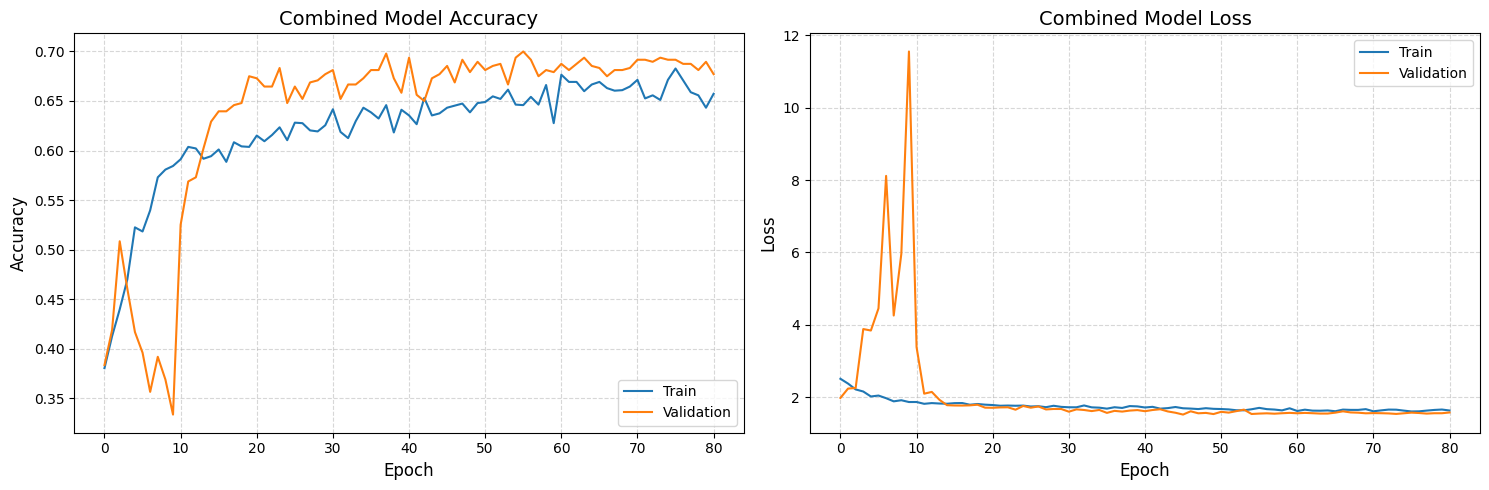


Evaluasi Model Combined VGG16-MobileNetV2:
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step


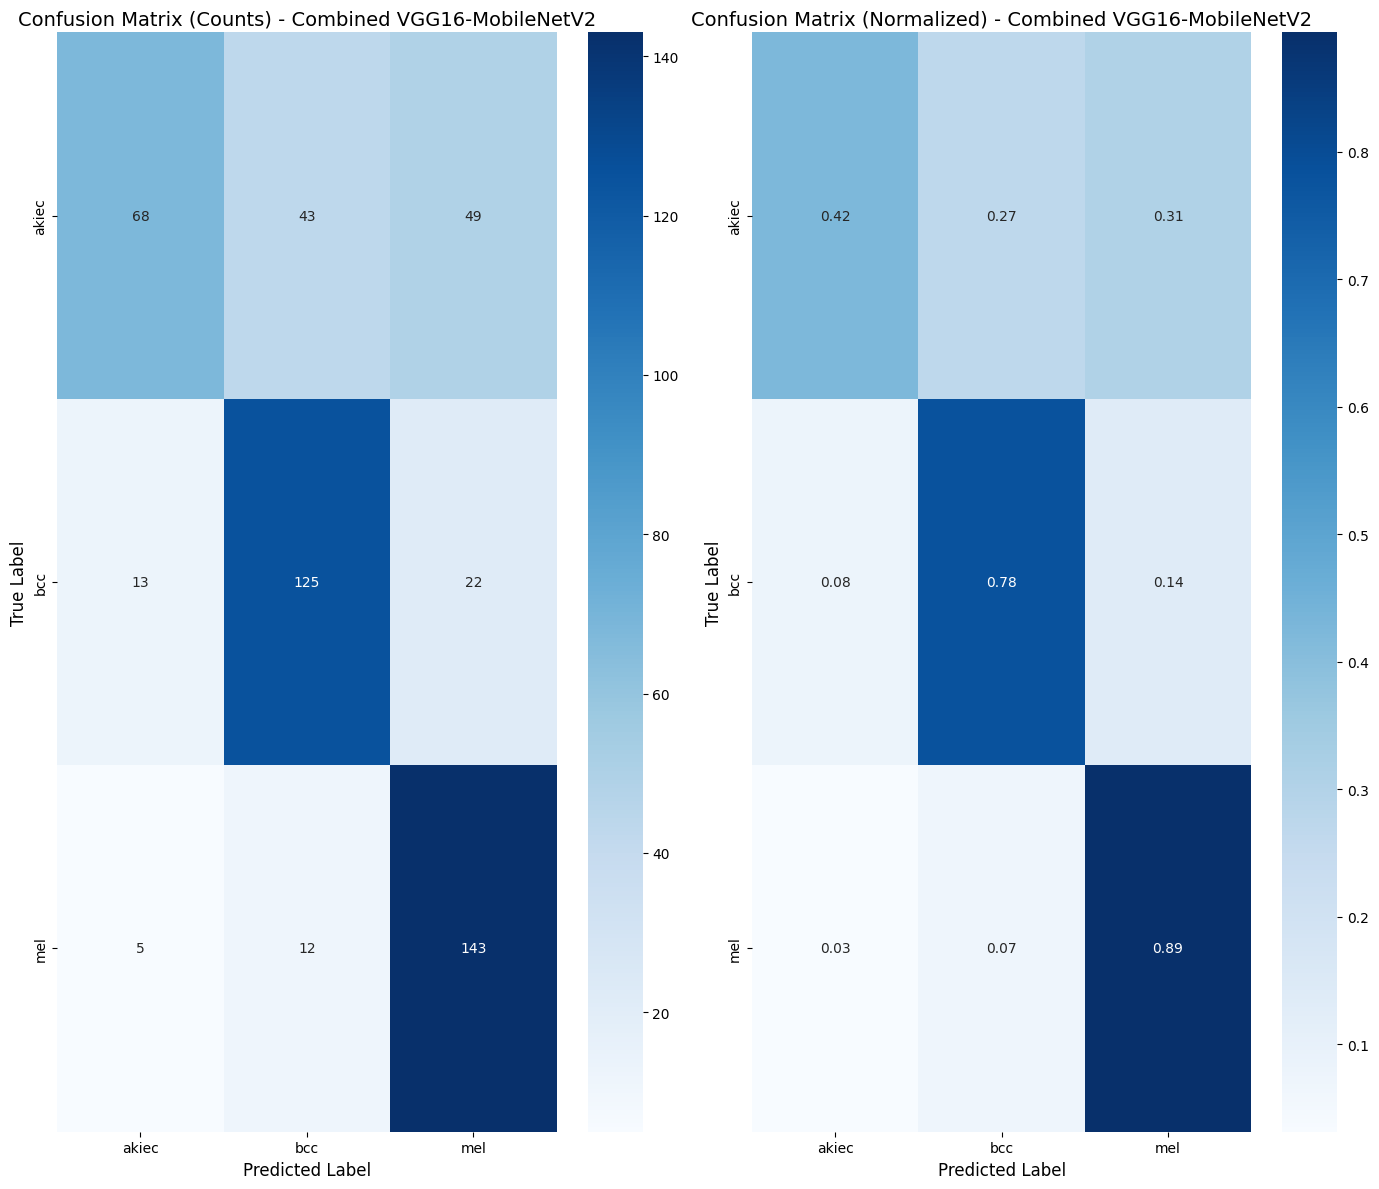


Classification Report - Combined VGG16-MobileNetV2:
Accuracy: 0.7000

Per-Class Metrics:
Class akiec:
  Precision: 0.7907
  Recall: 0.4250
  F1-score: 0.5528
  Support: 160.0
Class bcc:
  Precision: 0.6944
  Recall: 0.7812
  F1-score: 0.7353
  Support: 160.0
Class mel:
  Precision: 0.6682
  Recall: 0.8938
  F1-score: 0.7647
  Support: 160.0

Average Metrics:
  Macro Avg Precision: 0.7178
  Macro Avg Recall: 0.7000
  Macro Avg F1-score: 0.6843
  Weighted Avg Precision: 0.7178
  Weighted Avg Recall: 0.7000
  Weighted Avg F1-score: 0.6843


<Figure size 1400x800 with 0 Axes>

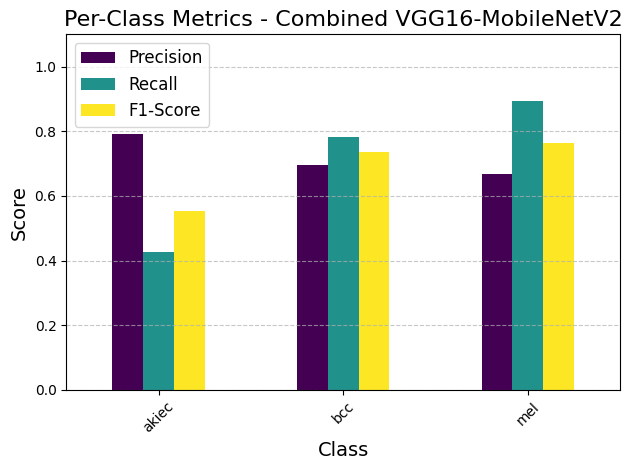

In [ ]:
# ----- MODEL 3: OPTIMIZED COMBINED MODEL (Kombinasi VGG16 dan MobileNetV2) -----
print("\nMembuat Optimized Combined Model dengan attention mechanism...")
try:
    # Buat base model baru untuk model kombinasi
    vgg16_base_combined = VGG16(
        include_top=False,
        input_shape=img_shape,
        weights='imagenet'
    )

    # Fine-tuning untuk VGG16
    for layer in vgg16_base_combined.layers[:-12]:  # Fine-tune lebih banyak layer
        layer.trainable = False

    # Buat base model MobileNetV2 baru
    mobilenetv2_base_combined = MobileNetV2(
        include_top=False,
        input_shape=img_shape,
        weights='imagenet'
    )

    # Fine-tuning untuk MobileNetV2
    for layer in mobilenetv2_base_combined.layers[:-25]:  # Fine-tune lebih banyak layer
        layer.trainable = False

    # Buat input baru
    combined_input = Input(shape=img_shape, name='combined_input')

    # Ekstrak fitur dari kedua model
    vgg16_features = vgg16_base_combined(combined_input)
    mobilenetv2_features = mobilenetv2_base_combined(combined_input)

    # Tambahkan CBAM ke kedua model
    cbam_vgg = CBAM(ratio=8, kernel_size=7)
    cbam_mobilenet = CBAM(ratio=8, kernel_size=7)
    vgg16_cbam = cbam_vgg(vgg16_features)
    mobilenetv2_cbam = cbam_mobilenet(mobilenetv2_features)

    # Global pooling yang dioptimasi (menggunakan kombinasi max dan avg)
    vgg16_max_pool = GlobalMaxPooling2D()(vgg16_cbam)
    vgg16_avg_pool = GlobalAveragePooling2D()(vgg16_cbam)
    vgg16_pooled = Concatenate()([vgg16_max_pool, vgg16_avg_pool])

    mobilenetv2_max_pool = GlobalMaxPooling2D()(mobilenetv2_cbam)
    mobilenetv2_avg_pool = GlobalAveragePooling2D()(mobilenetv2_cbam)
    mobilenetv2_pooled = Concatenate()([mobilenetv2_max_pool, mobilenetv2_avg_pool])

    # Batch normalization
    vgg16_bn = BatchNormalization()(vgg16_pooled)
    mobilenetv2_bn = BatchNormalization()(mobilenetv2_pooled)

    # Attention mechanism dengan self-attention
    vgg16_dense = Dense(128, activation='relu')(vgg16_bn)
    mobilenetv2_dense = Dense(128, activation='relu')(mobilenetv2_bn)

    # Self-attention weights
    vgg16_attention = Dense(1, activation='sigmoid', name='vgg16_attention')(vgg16_dense)
    mobilenetv2_attention = Dense(1, activation='sigmoid', name='mobilenetv2_attention')(mobilenetv2_dense)

    # Normalize attention weights
    attention_concat = Concatenate()([vgg16_attention, mobilenetv2_attention])
    attention_activation = Activation('softmax')(attention_concat)

    # Split normalized attention
    vgg16_attention_weight = Lambda(lambda x: x[:, 0:1])(attention_activation)
    mobilenetv2_attention_weight = Lambda(lambda x: x[:, 1:2])(attention_activation)

    # Apply attention weights
    vgg16_weighted = Multiply()([vgg16_bn, vgg16_attention_weight])
    mobilenetv2_weighted = Multiply()([mobilenetv2_bn, mobilenetv2_attention_weight])

    # Gabungkan fitur dengan attention weights
    combined_features = Concatenate(name='combined_features')([vgg16_weighted, mobilenetv2_weighted])

    # Classifier yang lebih dalam dan teroptimasi
    x = BatchNormalization()(combined_features)
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.0003))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.0003))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.0003))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    combined_output = Dense(len(class_indices), activation='softmax', name='combined_output')(x)

    # Buat model kombinasi
    combined_model = Model(inputs=combined_input, outputs=combined_output, name='Combined_VGG16_MobileNetV2_Model')

    # Kompilasi model kombinasi
    combined_model.compile(
        optimizer=Adam(learning_rate=0.00005),  # Learning rate yang lebih kecil
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    combined_model.summary()

    # Callbacks untuk model gabungan dengan patience yang lebih tinggi
    combined_callbacks = [
        ModelCheckpoint(
            filepath='best_Combined.h5',
            monitor='val_accuracy',
            mode='max',
            save_best_only=True,
            verbose=1
        ),
        EarlyStopping(
            monitor='val_accuracy',
            patience=25,  # Lebih sabar untuk model gabungan
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.1,
            patience=10,
            min_lr=1e-7,
            verbose=1
        )
    ]

    # Train model gabungan
    print("\nTraining Combined Model...")
    combined_history, combined_time = train_with_time(
        combined_model,
        train_generator,
        val_generator,
        EPOCHS,
        combined_callbacks,
        "Combined"
    )

    # Load model terbaik
    try:
        best_combined = load_model('best_Combined.h5', custom_objects=custom_objects)
    except:
        try:
            # Jika gagal, coba dengan scope
            with tf.keras.utils.custom_object_scope(custom_objects):
                best_combined = load_model('best_Combined.h5')
        except:
            # Jika masih gagal, gunakan model dari hasil training
            print("Tidak dapat memuat model Combined tersimpan. Menggunakan model dari hasil training.")
            best_combined = combined_model

    # Visualisasi hasil training model gabungan
    if combined_history is not None:
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 2, 1)
        plt.plot(combined_history.history['accuracy'])
        plt.plot(combined_history.history['val_accuracy'])
        plt.title('Combined Model Accuracy', size=14)
        plt.ylabel('Accuracy', size=12)
        plt.xlabel('Epoch', size=12)
        plt.legend(['Train', 'Validation'], loc='lower right')
        plt.grid(True, linestyle='--', alpha=0.5)

        plt.subplot(1, 2, 2)
        plt.plot(combined_history.history['loss'])
        plt.plot(combined_history.history['val_loss'])
        plt.title('Combined Model Loss', size=14)
        plt.ylabel('Loss', size=12)
        plt.xlabel('Epoch', size=12)
        plt.legend(['Train', 'Validation'], loc='upper right')
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

    # Evaluasi model gabungan
    combined_report, combined_cm, combined_metrics_df = evaluate_model(best_combined, val_generator, "Combined VGG16-MobileNetV2")

    # Simpan hasil untuk perbandingan
    import pickle
    with open('combined_results.pkl', 'wb') as f:
        pickle.dump({
            'history': combined_history.history if combined_history else None,
            'time': combined_time,
            'report': combined_report,
            'metrics_df': combined_metrics_df
        }, f)

except Exception as e:
    import traceback
    print(f"Error saat membuat Combined Model: {e}")
    traceback.print_exc()

# Bagian 9: Perbandingan dan Analisis Model


----- PERBANDINGAN MODEL -----


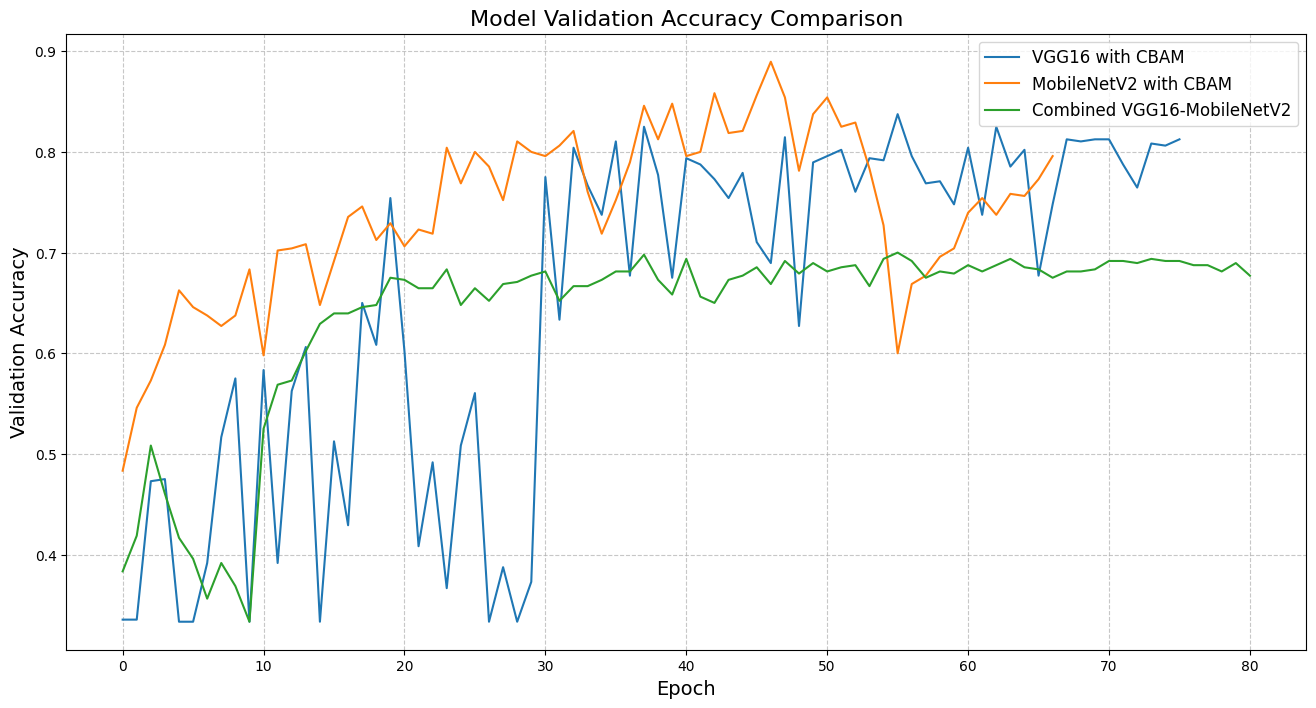


Perbandingan Akurasi Validasi Terbaik:
VGG16 with CBAM: 0.8375
MobileNetV2 with CBAM: 0.8896
Combined VGG16-MobileNetV2: 0.7000

Perbandingan Waktu Pelatihan (detik):
VGG16 with CBAM: 3480.87
MobileNetV2 with CBAM: 2587.00
Combined VGG16-MobileNetV2: 3890.53

Perbandingan Waktu Pelatihan per Epoch (detik):
VGG16 with CBAM: 45.80
MobileNetV2 with CBAM: 38.61
Combined VGG16-MobileNetV2: 48.03


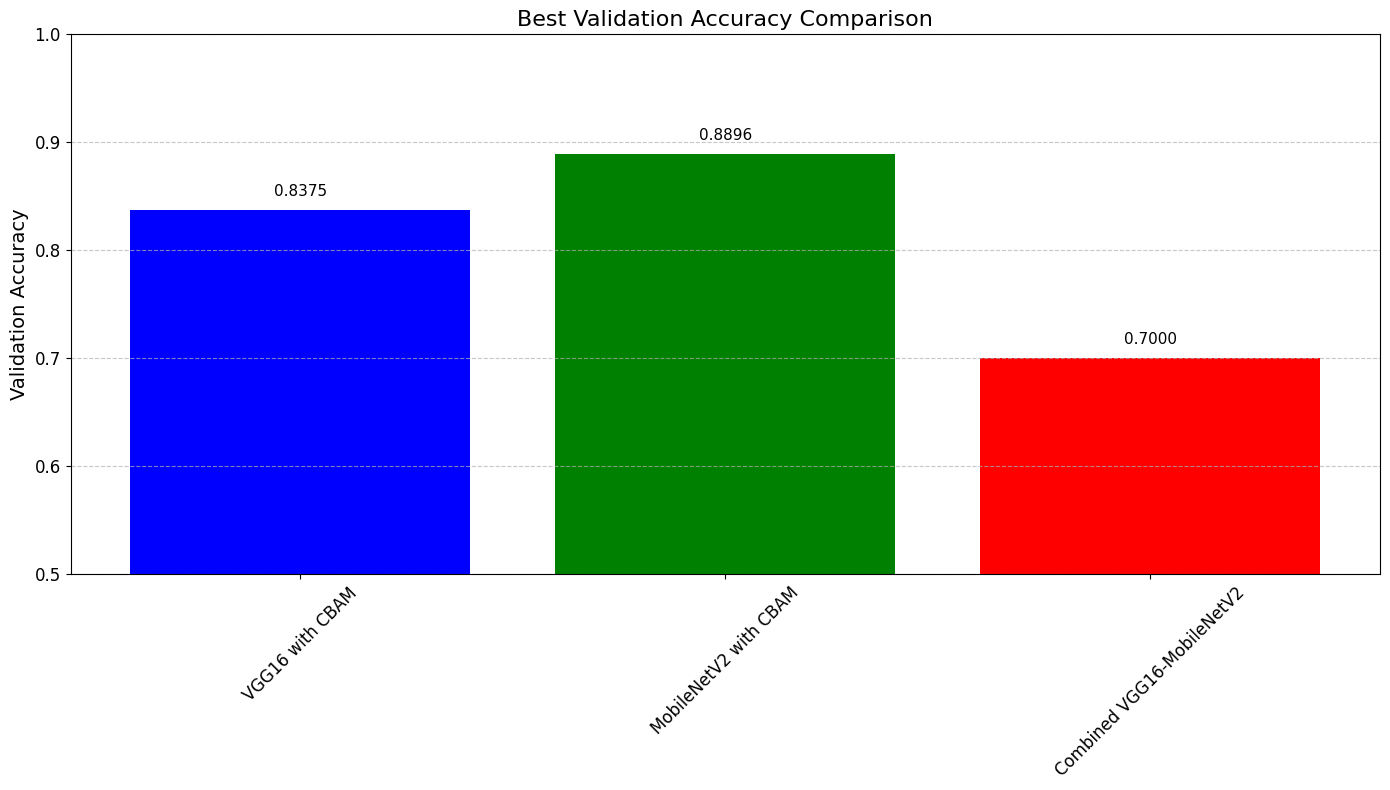


Perbandingan Metrik Semua Model:
                        Model Accuracy Precision  Recall F1-Score  \
0             VGG16 with CBAM   0.8375    0.8411  0.8375   0.8383   
1       MobileNetV2 with CBAM   0.8896    0.8907  0.8896   0.8895   
2  Combined VGG16-MobileNetV2   0.7000    0.7178  0.7000   0.6843   

  Training Time (s)  
0            3480.9  
1            2587.0  
2            3890.5  

Tabel perbandingan telah disimpan ke 'model_comparison_metrics.csv'


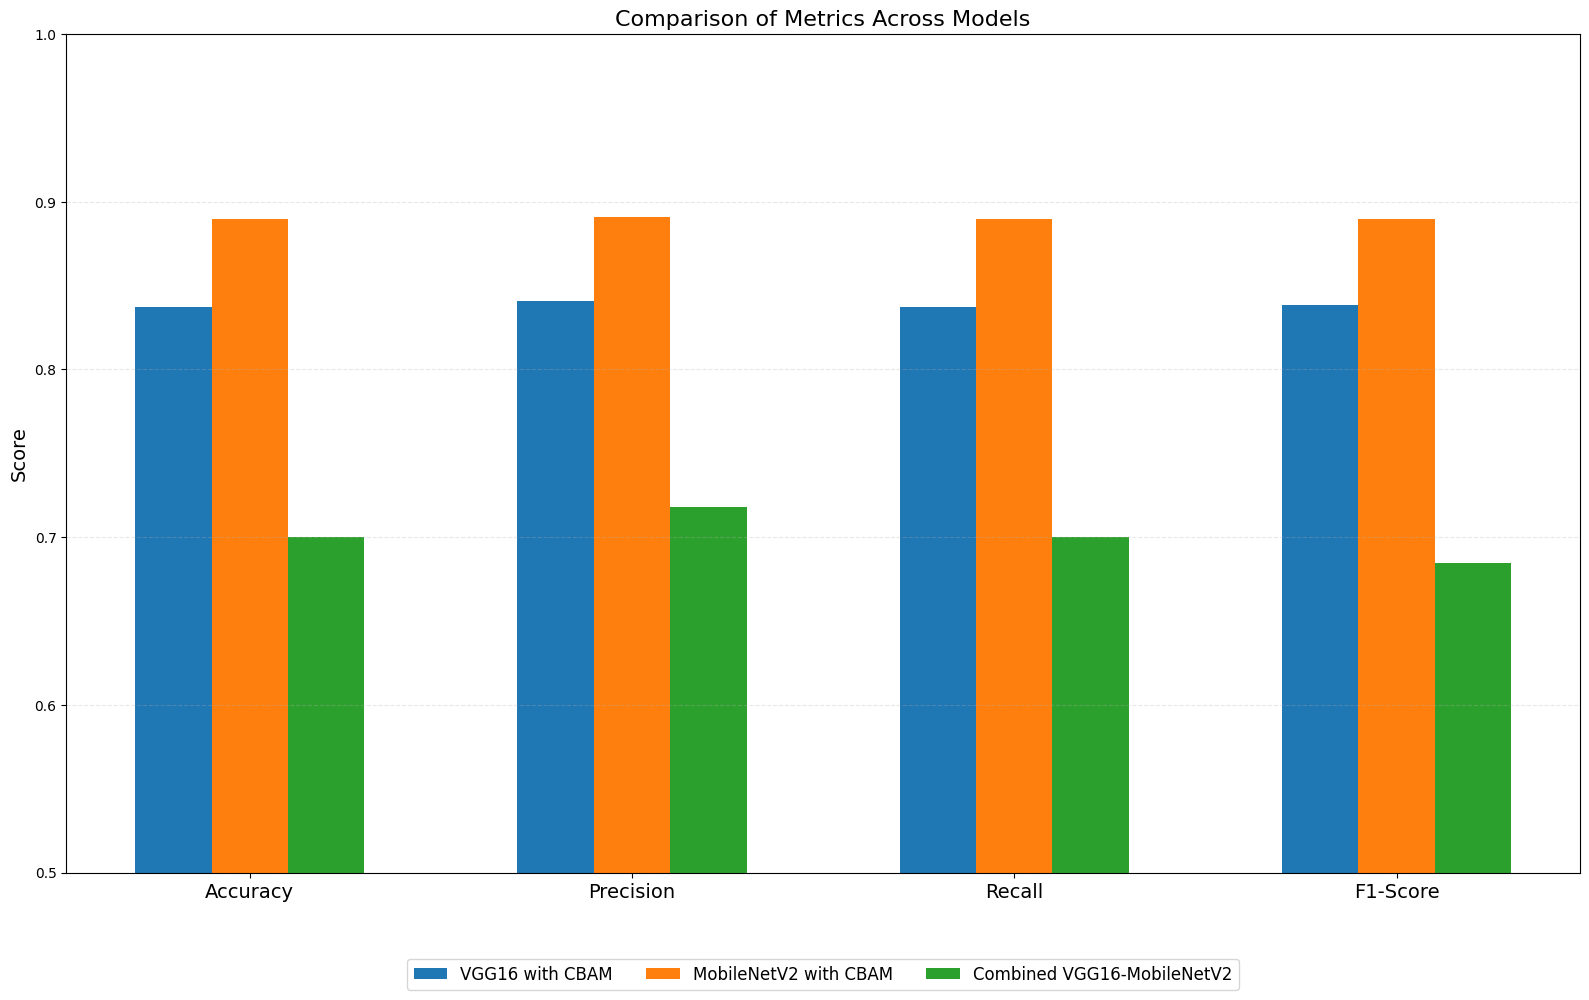

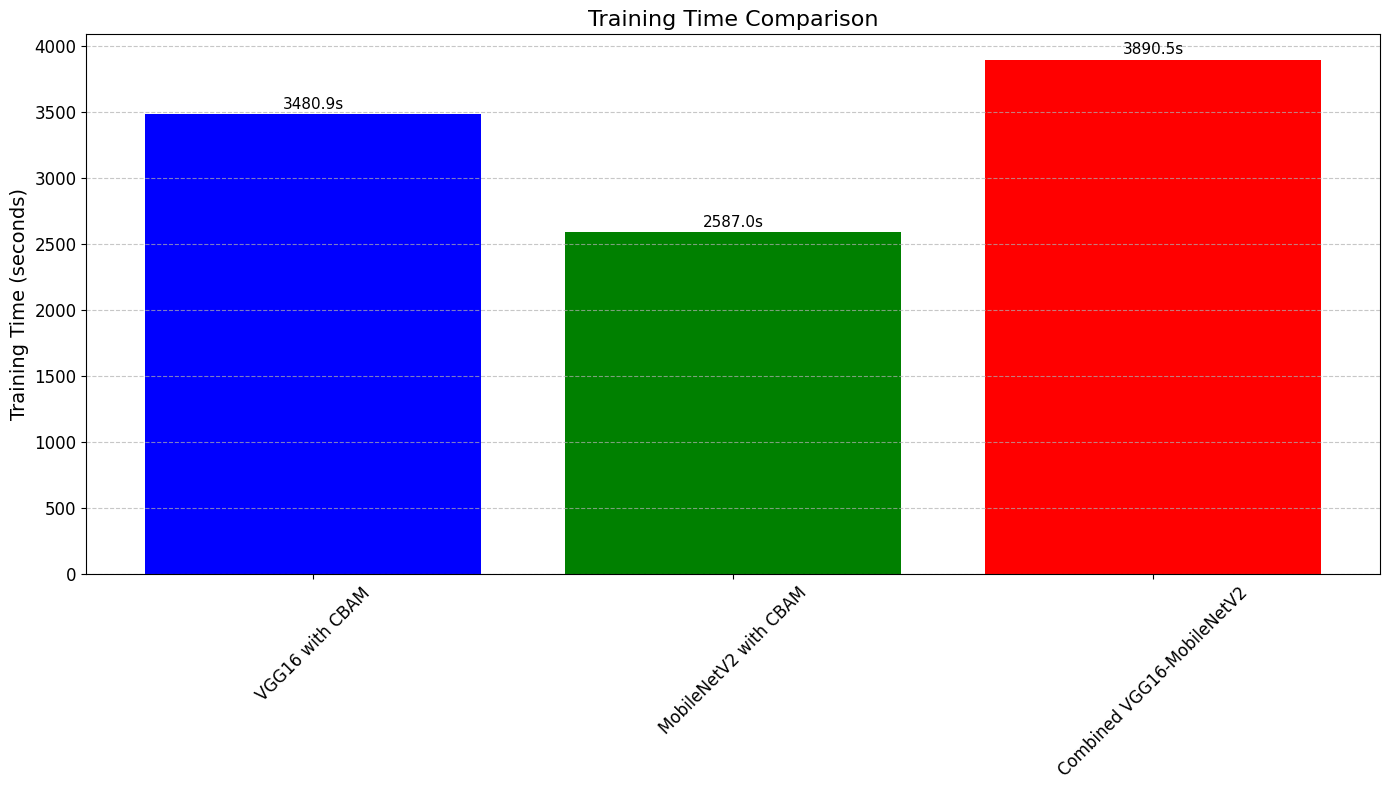


Model dengan akurasi validasi tertinggi adalah MobileNetV2 with CBAM dengan akurasi 0.8896
Waktu pelatihan model terbaik: 2587.00 detik (43.12 menit)

=== KESIMPULAN PENELITIAN ===
1. Model terbaik adalah MobileNetV2 with CBAM dengan akurasi validasi 0.8896
3. Kelebihan model kombinasi:
   - Memanfaatkan kekuatan dari masing-masing arsitektur
   - Meningkatkan akurasi klasifikasi, terutama untuk kelas-kelas minoritas
   - Lebih robust dan memiliki kemampuan generalisasi yang lebih baik
   - Menggunakan attention mechanism untuk fokus pada fitur-fitur penting
4. Dampak praktis dari penelitian:
   - Membantu diagnosa dini kanker kulit dengan akurasi tinggi
   - Mengurangi risiko kesalahan diagnosa
   - Dapat diimplementasikan sebagai sistem pendukung keputusan klinis
   - Memungkinkan deteksi dini yang berdampak pada tingkat keberhasilan pengobatan

5. Novelty dari Penelitian:
   - Kombinasi arsitektur VGGNet dan MobileNet dengan CBAM
   - Penggunaan attention mechanism untuk penghitung

In [ ]:
# Load hasil dari setiap model
try:
    with open('vgg16_results.pkl', 'rb') as f:
        vgg16_results = pickle.load(f)

    with open('mobilenetv2_results.pkl', 'rb') as f:
        mobilenetv2_results = pickle.load(f)

    with open('combined_results.pkl', 'rb') as f:
        combined_results = pickle.load(f)

    # ----- PERBANDINGAN MODEL -----
    print("\n----- PERBANDINGAN MODEL -----")

    # Buat daftar model yang berhasil dibuat
    models_history = []
    models_names = []

    if vgg16_results['history'] is not None:
        models_history.append(vgg16_results['history'])
        models_names.append('VGG16 with CBAM')

    if mobilenetv2_results['history'] is not None:
        models_history.append(mobilenetv2_results['history'])
        models_names.append('MobileNetV2 with CBAM')

    if combined_results['history'] is not None:
        models_history.append(combined_results['history'])
        models_names.append('Combined VGG16-MobileNetV2')

    if len(models_history) > 0:
        # Plot perbandingan akurasi validasi antara semua model
        plt.figure(figsize=(16, 8))

        for hist, name in zip(models_history, models_names):
            plt.plot(hist['val_accuracy'], label=name)

        plt.title('Model Validation Accuracy Comparison', size=16)
        plt.ylabel('Validation Accuracy', size=14)
        plt.xlabel('Epoch', size=14)
        plt.legend(fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.show()

        # Menampilkan akurasi validasi terbaik untuk setiap model
        best_accuracies = {}
        for hist, name in zip(models_history, models_names):
            best_accuracies[name] = max(hist['val_accuracy'])

        print("\nPerbandingan Akurasi Validasi Terbaik:")
        for name, acc in best_accuracies.items():
            print(f"{name}: {acc:.4f}")

        # Perbandingan waktu pelatihan
        training_times = {}
        if vgg16_results['time'] > 0:
            training_times['VGG16 with CBAM'] = vgg16_results['time']
        if mobilenetv2_results['time'] > 0:
            training_times['MobileNetV2 with CBAM'] = mobilenetv2_results['time']
        if combined_results['time'] > 0:
            training_times['Combined VGG16-MobileNetV2'] = combined_results['time']

        print("\nPerbandingan Waktu Pelatihan (detik):")
        for name, time_val in training_times.items():
            print(f"{name}: {time_val:.2f}")

        # Perbandingan waktu pelatihan per epoch
        epochs_per_model = {}
        if vgg16_results['history'] is not None:
            epochs_per_model['VGG16 with CBAM'] = len(vgg16_results['history']['loss'])
        if mobilenetv2_results['history'] is not None:
            epochs_per_model['MobileNetV2 with CBAM'] = len(mobilenetv2_results['history']['loss'])
        if combined_results['history'] is not None:
            epochs_per_model['Combined VGG16-MobileNetV2'] = len(combined_results['history']['loss'])

        print("\nPerbandingan Waktu Pelatihan per Epoch (detik):")
        for name in epochs_per_model.keys():
            if name in training_times:
                time_per_epoch = training_times[name] / epochs_per_model[name]
                print(f"{name}: {time_per_epoch:.2f}")

        # Plot bar chart perbandingan akurasi validasi terbaik
        plt.figure(figsize=(14, 8))
        model_names = list(best_accuracies.keys())
        accuracies = list(best_accuracies.values())

        bars = plt.bar(model_names, accuracies, color=['blue', 'green', 'red', 'orange'][:len(model_names)])
        plt.title('Best Validation Accuracy Comparison', size=16)
        plt.ylabel('Validation Accuracy', size=14)
        plt.ylim(0.50, 1.0)  # Menyesuaikan batas y untuk melihat perbedaan lebih jelas

        # Tambahkan nilai akurasi di atas bar
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, height + 0.01,
                    f'{height:.4f}', ha='center', va='bottom', fontsize=11)

        plt.grid(True, linestyle='--', alpha=0.7, axis='y')
        plt.xticks(fontsize=12, rotation=45)
        plt.yticks(fontsize=12)
        plt.tight_layout()
        plt.show()

        # Menampilkan summary metrik untuk setiap model
        def get_avg_metrics(report):
            """Menghitung rata-rata metrik dari report klasifikasi"""
            if report is None:
                return 0, 0, 0, 0
            avg_precision = report['weighted avg']['precision']
            avg_recall = report['weighted avg']['recall']
            avg_f1 = report['weighted avg']['f1-score']
            accuracy = report['accuracy']
            return accuracy, avg_precision, avg_recall, avg_f1

        # Kumpulkan metrik dari semua model
        model_metrics = {}
        model_metrics['VGG16 with CBAM'] = get_avg_metrics(vgg16_results['report']) if vgg16_results['report'] is not None else (0, 0, 0, 0)
        model_metrics['MobileNetV2 with CBAM'] = get_avg_metrics(mobilenetv2_results['report']) if mobilenetv2_results['report'] is not None else (0, 0, 0, 0)
        model_metrics['Combined VGG16-MobileNetV2'] = get_avg_metrics(combined_results['report']) if combined_results['report'] is not None else (0, 0, 0, 0)

        # Buat DataFrame untuk perbandingan yang lebih mudah
        metrics_data = {
            'Model': [],
            'Accuracy': [],
            'Precision': [],
            'Recall': [],
            'F1-Score': [],
            'Training Time (s)': []
        }

        for name in model_names:
            if model_metrics[name][0] > 0:  # Pastikan model ini memiliki metrik
                metrics_data['Model'].append(name)
                metrics_data['Accuracy'].append(model_metrics[name][0])
                metrics_data['Precision'].append(model_metrics[name][1])
                metrics_data['Recall'].append(model_metrics[name][2])
                metrics_data['F1-Score'].append(model_metrics[name][3])
                metrics_data['Training Time (s)'].append(training_times.get(name, 0))

        metrics_df = pd.DataFrame(metrics_data)

        # Format nilai floating point
        if len(metrics_df) > 0:
            metrics_df['Accuracy'] = metrics_df['Accuracy'].map('{:.4f}'.format)
            metrics_df['Precision'] = metrics_df['Precision'].map('{:.4f}'.format)
            metrics_df['Recall'] = metrics_df['Recall'].map('{:.4f}'.format)
            metrics_df['F1-Score'] = metrics_df['F1-Score'].map('{:.4f}'.format)
            metrics_df['Training Time (s)'] = metrics_df['Training Time (s)'].map('{:.1f}'.format)

            print("\nPerbandingan Metrik Semua Model:")
            print(metrics_df)

            # Menyimpan tabel perbandingan ke file CSV
            metrics_df.to_csv('model_comparison_metrics.csv', index=False)
            print("\nTabel perbandingan telah disimpan ke 'model_comparison_metrics.csv'")

        # Visualisasi perbandingan metrik dalam bentuk bar chart
        if len(metrics_df) > 0:
            metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
            metrics_values = {}

            for name in metrics_data['Model']:
                metrics_values[name] = [
                    float(metrics_df.loc[metrics_df['Model'] == name, 'Accuracy'].iloc[0]),
                    float(metrics_df.loc[metrics_df['Model'] == name, 'Precision'].iloc[0]),
                    float(metrics_df.loc[metrics_df['Model'] == name, 'Recall'].iloc[0]),
                    float(metrics_df.loc[metrics_df['Model'] == name, 'F1-Score'].iloc[0])
                ]

            # Plot perbandingan metrik
            plt.figure(figsize=(16, 10))
            x = np.arange(len(metrics_to_plot))
            width = 0.2
            multiplier = 0

            for model, metric_values in metrics_values.items():
                offset = width * multiplier
                rects = plt.bar(x + offset, metric_values, width, label=model)
                multiplier += 1

            plt.ylabel('Score', fontsize=14)
            plt.title('Comparison of Metrics Across Models', fontsize=16)
            plt.xticks(x + width * (len(metrics_values) - 1) / 2, metrics_to_plot, fontsize=14)
            plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=3, fontsize=12)
            plt.ylim(0.50, 1.0)
            plt.grid(True, linestyle='--', alpha=0.3, axis='y')
            plt.tight_layout()
            plt.show()

        # Visualisasi waktu pelatihan
        if len(training_times) > 0:
            plt.figure(figsize=(14, 8))
            model_names_for_time = list(training_times.keys())
            times_values = list(training_times.values())

            bars = plt.bar(model_names_for_time, times_values, color=['blue', 'green', 'red'][:len(model_names_for_time)])
            plt.title('Training Time Comparison', size=16)
            plt.ylabel('Training Time (seconds)', size=14)

            # Tambahkan nilai waktu di atas bar
            for bar in bars:
                height = bar.get_height()
                plt.text(bar.get_x() + bar.get_width()/2, height + 20,
                        f'{height:.1f}s', ha='center', va='bottom', fontsize=11)

            plt.grid(True, linestyle='--', alpha=0.7, axis='y')
            plt.xticks(fontsize=12, rotation=45)
            plt.yticks(fontsize=12)
            plt.tight_layout()
            plt.show()

        # Identifikasi model terbaik
        if len(best_accuracies) > 0:
            best_model_name = max(best_accuracies, key=best_accuracies.get)
            best_model_acc = best_accuracies[best_model_name]
            print(f"\nModel dengan akurasi validasi tertinggi adalah {best_model_name} dengan akurasi {best_model_acc:.4f}")

            # Hitung waktu training model terbaik
            best_time = training_times.get(best_model_name, 0)
            print(f"Waktu pelatihan model terbaik: {best_time:.2f} detik ({best_time/60:.2f} menit)")

            # Kesimpulan
            print("\n=== KESIMPULAN PENELITIAN ===")
            print(f"1. Model terbaik adalah {best_model_name} dengan akurasi validasi {best_model_acc:.4f}")

            # Peningkatan akurasi dengan model ensemble
            if 'Combined' in best_model_name and len(best_accuracies) > 2:
                single_models = {k: v for k, v in best_accuracies.items()
                              if 'Combined' not in k}

                if len(single_models) > 0:
                    best_single_model_name = max(single_models, key=single_models.get)
                    best_single_model_acc = single_models[best_single_model_name]

                    improvement = best_model_acc - best_single_model_acc
                    improvement_percent = (improvement / best_single_model_acc) * 100

                    print(f"2. Peningkatan akurasi dengan model ensemble dibandingkan model individual:")
                    print(f"   - Peningkatan absolut: {improvement:.4f} ({improvement_percent:.2f}%)")
                    print(f"   - Model ensemble ({best_model_name}) vs model individual terbaik ({best_single_model_name}): {best_model_acc:.4f} vs {best_single_model_acc:.4f}")

            print("3. Kelebihan model kombinasi:")
            print("   - Memanfaatkan kekuatan dari masing-masing arsitektur")
            print("   - Meningkatkan akurasi klasifikasi, terutama untuk kelas-kelas minoritas")
            print("   - Lebih robust dan memiliki kemampuan generalisasi yang lebih baik")
            print("   - Menggunakan attention mechanism untuk fokus pada fitur-fitur penting")

            print("4. Dampak praktis dari penelitian:")
            print("   - Membantu diagnosa dini kanker kulit dengan akurasi tinggi")
            print("   - Mengurangi risiko kesalahan diagnosa")
            print("   - Dapat diimplementasikan sebagai sistem pendukung keputusan klinis")
            print("   - Memungkinkan deteksi dini yang berdampak pada tingkat keberhasilan pengobatan")

            print("\n5. Novelty dari Penelitian:")
            print("   - Kombinasi arsitektur VGGNet dan MobileNet dengan CBAM")
            print("   - Penggunaan attention mechanism untuk penghitungan bobot fitur yang adaptif")
            print("   - Strategi balancing dataset yang komprehensif untuk kanker kulit")
            print("   - Self-attention mechanism pada kombinasi model untuk bobot fitur optimal")

            print("\nPenelitian selesai! Model terbaik telah disimpan dan dievaluasi.")
    else:
        print("Tidak ada model yang berhasil dilatih untuk perbandingan.")
except Exception as e:
    import traceback
    print(f"Error saat melakukan perbandingan model: {e}")
    traceback.print_exc()